#Requirements

##Tuner

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.7 MB/s eta 0:00:00


##Library

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange #basically pakage that show progress bar in loops
from itertools import chain #function used to create efficient looping in python

#package used for image processing
from skimage.io import imread, imshow, concatenate_images
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import tensorflow as tf

from keras.models import Model, load_model
#input is used to instantiate a keras tensor
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, UpSampling2D, Concatenate#batchnormalization -> transformation that maintain mean close to 0 and SD close to 1
from keras.layers import Lambda, RepeatVector, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D, GlobalMaxPool2D
from keras.layers import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau #save weights at some freq, reduce learning rate when metric stop improving
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import normalize, to_categorical

# import matplotlib.image as mpimg
import cv2
from google.colab.patches import cv2_imshow

import os
import cv2
import numpy as np
from skimage.io import imread
from tqdm.notebook import tqdm

from keras.optimizers import Adam
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch
from keras import backend as K

##GDrive

In [ ]:
# Check is Link to Drive is OK, then dock to drive
google = !if [ -d 'GDrive/' ]; then echo "1" ; else echo "0"; fi
if (google[0] is '0' ):
  from google.colab import drive
  drive.mount('/content/GDrive/')
!if [ -d 'GDrive/' ]; then echo "Connection to Google drive successful" ; else echo "Error to connect to Google drive"; fi


<>:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipython-input-3-1523835982.py:3: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if (google[0] is '0' ):


Mounted at /content/GDrive/
Connection to Google drive successful


##Function

###Resize


In [ ]:
def resize_image(image, target_size):
    h, w = image.shape[:2]
    new_h, new_w = target_size

    if len(image.shape) == 3:
        channels = image.shape[2]
        resized = np.zeros((new_h, new_w, channels), dtype=image.dtype)
    else:
        channels = 1
        image = image[:, :, np.newaxis]
        resized = np.zeros((new_h, new_w, 1), dtype=image.dtype)

    x_scale = w / new_w
    y_scale = h / new_h

    for y in range(new_h):
        for x in range(new_w):
            src_x = x * x_scale
            src_y = y * y_scale

            x0 = int(np.floor(src_x))
            x1 = min(x0 + 1, w - 1)
            y0 = int(np.floor(src_y))
            y1 = min(y0 + 1, h - 1)

            dx = src_x - x0
            dy = src_y - y0

            top = (1 - dx) * image[y0, x0] + dx * image[y0, x1]
            bottom = (1 - dx) * image[y1, x0] + dx * image[y1, x1]
            value = (1 - dy) * top + dy * bottom

            resized[y, x] = value

    if channels == 1:
        return resized[:, :, 0]
    return resized

###CLAHE

In [ ]:
import numpy as np
import cv2

def CalHistogram(channel):
    """
    Compute the histogram of one-channel image.
    """
    hist, _ = np.histogram(channel.flatten(), bins=256, range=[0, 256])
    return hist

def ClipHistogram(hist, clip_limit):
    """
    Clips the histogram by limiting each bin to the clip_limit and redistributes
    the clipped amount uniformly among all the bins.
    """
    excess = hist - clip_limit
    excess[excess < 0] = 0
    total_excess = np.sum(excess)

    # Clip the histogram
    hist = np.minimum(hist, clip_limit)

    # Redistribute the excess uniformly
    redist = total_excess // 256
    hist = hist + redist

    # Distribute the remainder sequentially
    remainder = total_excess % 256
    for i in range(256):
        if remainder <= 0:
            break
        hist[i] += 1
        remainder -= 1

    return hist

def CreateMapping(hist, block_size):
    """
    Calculates the mapping function (lookup table) from the clipped histogram using CDF.
    """
    cdf = np.cumsum(hist)
    cdf_min = cdf[np.nonzero(cdf)][0]
    mapping = np.round((cdf - cdf_min) / float(block_size - cdf_min) * 255).astype(np.uint8)
    return mapping

def ComputeMappings(image, n_rows, n_cols, cell_h, cell_w, clip_limit):
    """
    Computes mapping for each grid cell.
    Returns a 2D array (n_rows x n_cols) of mappings, each of shape (256,)
    """
    mappings = []
    for i in range(n_rows):
        row_maps = []
        for j in range(n_cols):
            y0, y1 = i * cell_h, (i + 1) * cell_h
            x0, x1 = j * cell_w, (j + 1) * cell_w
            cell = image[y0:y1, x0:x1]

            hist = CalHistogram(cell)
            clipped_hist = ClipHistogram(hist, clip_limit)
            mapping = CreateMapping(clipped_hist, cell.size)
            row_maps.append(mapping)
        mappings.append(row_maps)
    return mappings

def ApplyInterpolation(image, mappings, n_rows, n_cols, cell_h, cell_w):
    """
    Apply bilinear interpolation of mappings for full image construction.
    """
    height, width = image.shape
    result = np.zeros_like(image, dtype=np.uint8)

    for i in range(height):
        for j in range(width):
            row = min(i // cell_h, n_rows - 2)
            col = min(j // cell_w, n_cols - 2)

            y_ratio = (i - row * cell_h) / cell_h
            x_ratio = (j - col * cell_w) / cell_w

            mappings_ij = mappings[row][col]
            mappings_i1j = mappings[row + 1][col]
            mappings_ij1 = mappings[row][col + 1]
            mappings_i1j1 = mappings[row + 1][col + 1]

            pixel_val = image[i, j]

            top = (1 - x_ratio) * mappings_ij[pixel_val] + x_ratio * mappings_ij1[pixel_val]
            bottom = (1 - x_ratio) * mappings_i1j[pixel_val] + x_ratio * mappings_i1j1[pixel_val]
            interpolated_val = (1 - y_ratio) * top + y_ratio * bottom

            result[i, j] = np.clip(interpolated_val, 0, 255)

    return result

def HistogramEqualizationClaheGrayscale(image, clip_limit=10, grid_size=(8, 8)):
    """
    Applies CLAHE (manual) to a grayscale image.
    """
    height, width = image.shape
    n_rows, n_cols = grid_size
    cell_h, cell_w = height // n_rows, width // n_cols

    mappings = ComputeMappings(image, n_rows, n_cols, cell_h, cell_w, clip_limit)
    equalized_image = ApplyInterpolation(image, mappings, n_rows, n_cols, cell_h, cell_w)
    return equalized_image


In [ ]:
def apply_clahe_batch(T_images, clip_limit=4, grid_size=(4, 4)):
    processed_images = []

    for img in T_images:
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)
        clahe_img = HistogramEqualizationClaheGrayscale(img, clip_limit=clip_limit, grid_size=grid_size)
        processed_images.append(clahe_img)

    return np.array(processed_images)

###Normalization

In [ ]:
def min_max_normalize_batch(images):
    norm_images = []
    for img in images:
        img = img.astype(np.float32)
        norm = (img - img.min()) / (img.max() - img.min() + 1e-5)
        norm_images.append(norm)
    return np.array(norm_images)

###Evaluation Matrics

In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_f = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
    y_pred_f = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])

    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    denom = tf.reduce_sum(y_true_f + y_pred_f, axis=0)
    dice = (2. * intersection + smooth) / (denom + smooth)
    return tf.reduce_mean(dice)

class MeanIoUCustom(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='mean_iou', **kwargs):
        super(MeanIoUCustom, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.mean_iou = tf.keras.metrics.MeanIoU(num_classes=num_classes)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.argmax(y_true, axis=-1)
        self.mean_iou.update_state(y_true, y_pred)

    def result(self):
        return self.mean_iou.result()

    def reset_states(self):
        self.mean_iou.reset_states()


##Variable

In [ ]:
im_width = 128
im_height = 128
border = 5
n_classes = 6

#Load Image

In [ ]:
#getting all image and mask, and saving to X and y respectively
# tqdm is used to display the progress bar

def get_image_mask(all_patients):
    train_images = []
    train_masks = []
    index = 0
    for N, patient in tqdm_notebook(enumerate(all_patients), total= len(all_patients)):
        PATIENT_PATH = "/content/GDrive/MyDrive/AROI/AROI - online/24 patient/"+str(patient)
        pic_ids = os.listdir(PATIENT_PATH+"/raw/labeled") # list of names all images in the given path
        print(f"No. of images for patient {patient} = {len(pic_ids)}")
        for id_ in pic_ids:
            # Load images in google drive
            img = imread(PATIENT_PATH+"/raw/labeled/"+id_, as_gray = True)
            img = resize_image(img, (im_height, im_width))

            train_images.append(img)
            # Load masks
            mask = imread(PATIENT_PATH+"/mask/number/"+id_, as_gray = True)
            mask = resize_image(mask,(im_height, im_width))
            train_masks.append(mask)
            index +=1
    print("total images is : ", index)
    return train_images, train_masks

#counting the total number of pics in the dataset
ALL_PATIENT = "GDrive/MyDrive/AROI/AROI - online/24 patient"
patients = os.listdir(ALL_PATIENT) # list of names all images in the given path

#remove patient 23 since there is no labelled pics
# patients.remove('patient23')
# print(patients)
# patients = ['patient1']

T_image, T_mask = get_image_mask(patients)
T_image = np.array(T_image)
T_mask = np.array(T_mask)

/tmp/ipython-input-10-2568093106.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for N, patient in tqdm_notebook(enumerate(all_patients), total= len(all_patients)):


  0%|          | 0/24 [00:00<?, ?it/s]

No. of images for patient patient10 = 87
No. of images for patient patient17 = 21
No. of images for patient patient15 = 97
No. of images for patient patient18 = 61
No. of images for patient patient16 = 49
No. of images for patient patient14 = 31
No. of images for patient patient12 = 19
No. of images for patient patient11 = 21
No. of images for patient patient1 = 41
No. of images for patient patient13 = 30
No. of images for patient patient20 = 66
No. of images for patient patient4 = 56
No. of images for patient patient24 = 33
No. of images for patient patient2 = 68
No. of images for patient patient21 = 21
No. of images for patient patient19 = 21
No. of images for patient patient5 = 49
No. of images for patient patient22 = 31
No. of images for patient patient3 = 20
No. of images for patient patient23 = 31
No. of images for patient patient8 = 71
No. of images for patient patient9 = 73
No. of images for patient patient6 = 36
No. of images for patient patient7 = 103
total images is :  1136


##Save Image

In [ ]:
# Simpan array sebagai file .npy
np.save('/content/GDrive/MyDrive/T_image.npy', T_image)
np.save('/content/GDrive/MyDrive/T_mask.npy', T_mask)
np.savez('/content/GDrive/MyDrive/data.npz', images=T_image, masks=T_mask)

###Load Image from NP

In [ ]:
data = np.load('/content/GDrive/MyDrive/T_data.npz')
T_image = data['images']
T_mask = data['masks']

In [ ]:
import numpy as np
from collections import Counter

def hitung_gambar_per_kategori_dari_label_mask(T_mask_dataset, abaikan_kelas_0=True):
    """
    Menghitung jumlah gambar yang memiliki setiap kategori kelas dari dataset mask.
    Diasumsikan T_mask_dataset memiliki bentuk (jumlah_gambar, tinggi, lebar),
    di mana setiap piksel dalam gambar adalah ID kelas.

    Args:
        T_mask_dataset (np.array): Array NumPy 3D.
        abaikan_kelas_0 (bool): Jika True, kelas 0 (biasanya dianggap background)
                                tidak akan dihitung dalam kemunculan kategori.

    Returns:
        collections.Counter: Counter dengan ID kelas sebagai kunci dan
                             jumlah gambar yang memiliki kelas tersebut sebagai nilai.
                             Contoh: {0: 50, 1: 45, 2: 30, ...} berarti
                             kelas 0 ada di 50 gambar, kelas 1 ada di 45 gambar, dst.
    """
    if not isinstance(T_mask_dataset, np.ndarray) or T_mask_dataset.ndim != 3:
        print("Error: T_mask_dataset harus berupa array NumPy 3D (jumlah_gambar, tinggi, lebar).")
        return Counter()

    jumlah_gambar_total = T_mask_dataset.shape[0]
    # Counter untuk menyimpan berapa banyak gambar yang mengandung setiap kelas
    hitungan_kemunculan_kelas = Counter()

    print(f"Menganalisis {jumlah_gambar_total} gambar dalam T_mask_dataset...")
    for i in range(jumlah_gambar_total):
        mask_gambar_tunggal = T_mask_dataset[i, :, :]
        # Temukan semua ID kelas unik yang ada di dalam gambar (mask) saat ini
        kelas_unik_di_gambar_ini = np.unique(mask_gambar_tunggal)

        # Untuk setiap kelas unik yang ditemukan di gambar ini,
        # kita tandai bahwa kelas tersebut muncul di satu gambar lagi.
        for id_kelas in kelas_unik_di_gambar_ini:
            if abaikan_kelas_0 and id_kelas == 0:
                continue  # Lewati kelas 0 jika diminta (misalnya, jika itu background)
            hitungan_kemunculan_kelas[id_kelas] += 1

    return hitungan_kemunculan_kelas

# Anda sudah memiliki T_mask dari kode Anda:
# T_image, T_mask = get_image_mask(patients)
# T_image = np.array(T_image)
# T_mask = np.array(T_mask)

# Sekarang, panggil fungsi ini dengan T_mask Anda:

# Pilihan 1: Mengabaikan kelas 0 (jika kelas 0 adalah background dan tidak ingin dihitung)
# statistik_kategori = hitung_gambar_per_kategori_dari_label_mask(T_mask, abaikan_kelas_0=True)

# Pilihan 2: Menyertakan semua kelas, termasuk kelas 0
statistik_kategori = hitung_gambar_per_kategori_dari_label_mask(T_mask, abaikan_kelas_0=False)


print("\nJumlah gambar yang di dalamnya terdapat setiap kelas:")
if statistik_kategori:
    # Mengurutkan berdasarkan ID kelas untuk tampilan yang lebih rapi
    for id_kelas, jumlah_gambar_dengan_kelas_ini in sorted(statistik_kategori.items()):
        print(f"- Kelas {id_kelas}: terdapat di {jumlah_gambar_dengan_kelas_ini} gambar")
else:
    print("Tidak ada statistik yang dihasilkan. Pastikan T_mask tidak kosong dan valid.")

Menganalisis 1136 gambar dalam T_mask_dataset...

Jumlah gambar yang di dalamnya terdapat setiap kelas:
- Kelas 0: terdapat di 1136 gambar
- Kelas 1: terdapat di 1136 gambar
- Kelas 2: terdapat di 1136 gambar
- Kelas 3: terdapat di 1136 gambar
- Kelas 4: terdapat di 1136 gambar
- Kelas 5: terdapat di 1065 gambar
- Kelas 6: terdapat di 710 gambar
- Kelas 7: terdapat di 224 gambar


#Preprocess


##Clean Mask

In [ ]:
#Mengabungkan Mask 7 & 8 ke mask 5
print(T_mask.ndim)
for i in range(len(T_mask)):
    for j in range(im_width):
      for k in range(im_height):
        T_mask[i][j][k] = 5 if T_mask[i][j][k]>5 else T_mask[i][j][k]
np.unique(T_mask[0])

3


array([0, 1, 2, 3, 4, 5], dtype=uint8)

##Apply CLAHE

In [ ]:
T_image_clahe = apply_clahe_batch(T_image)
T_image_clahe = np.array(T_image_clahe)

shape of images (128, 128)
num images : 1136
shape of mask (128, 128)
num mask : 1136
num_classes : [0 1 2 3 4 5]


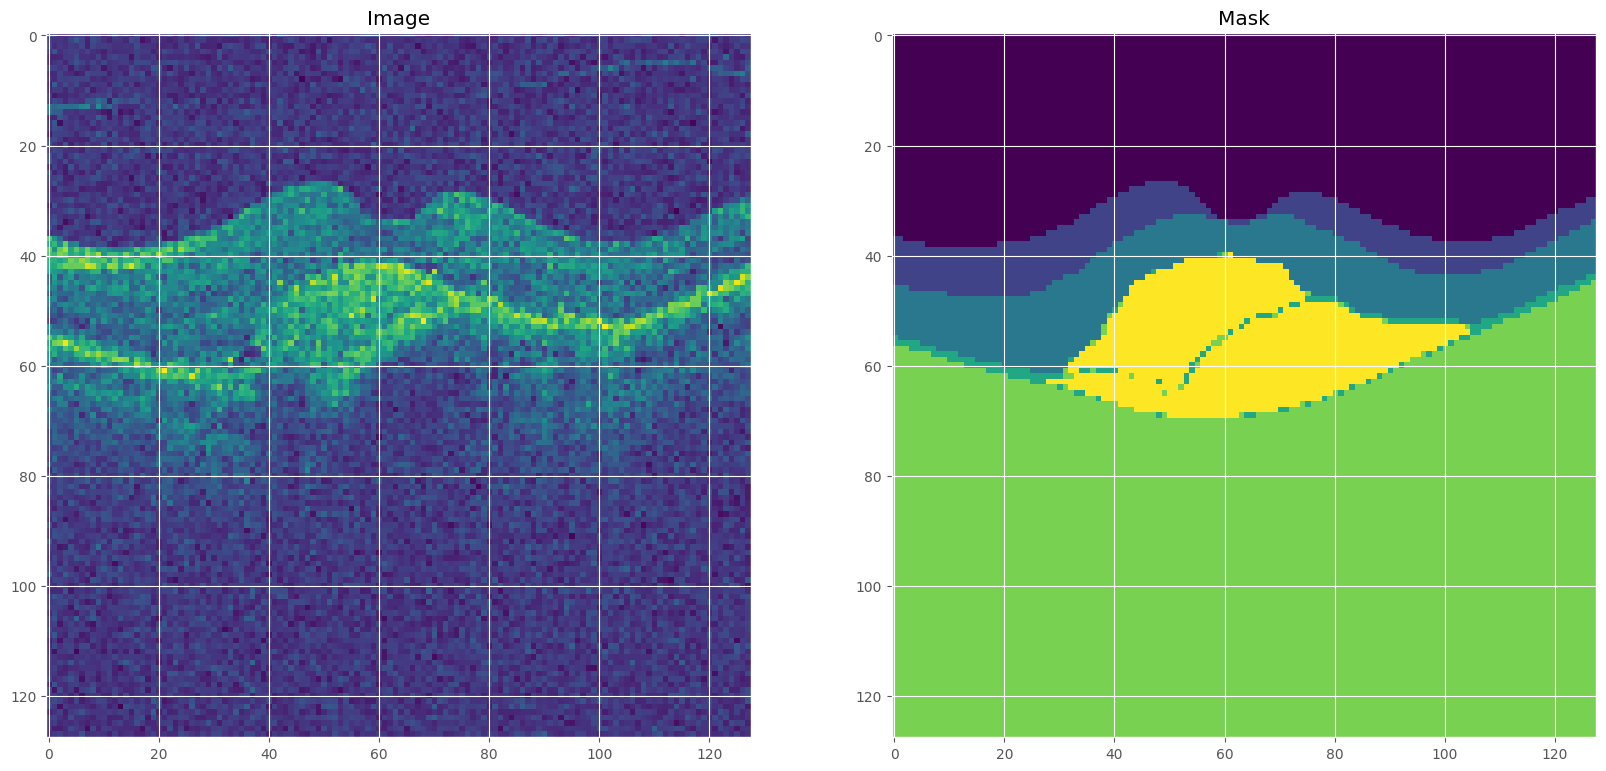

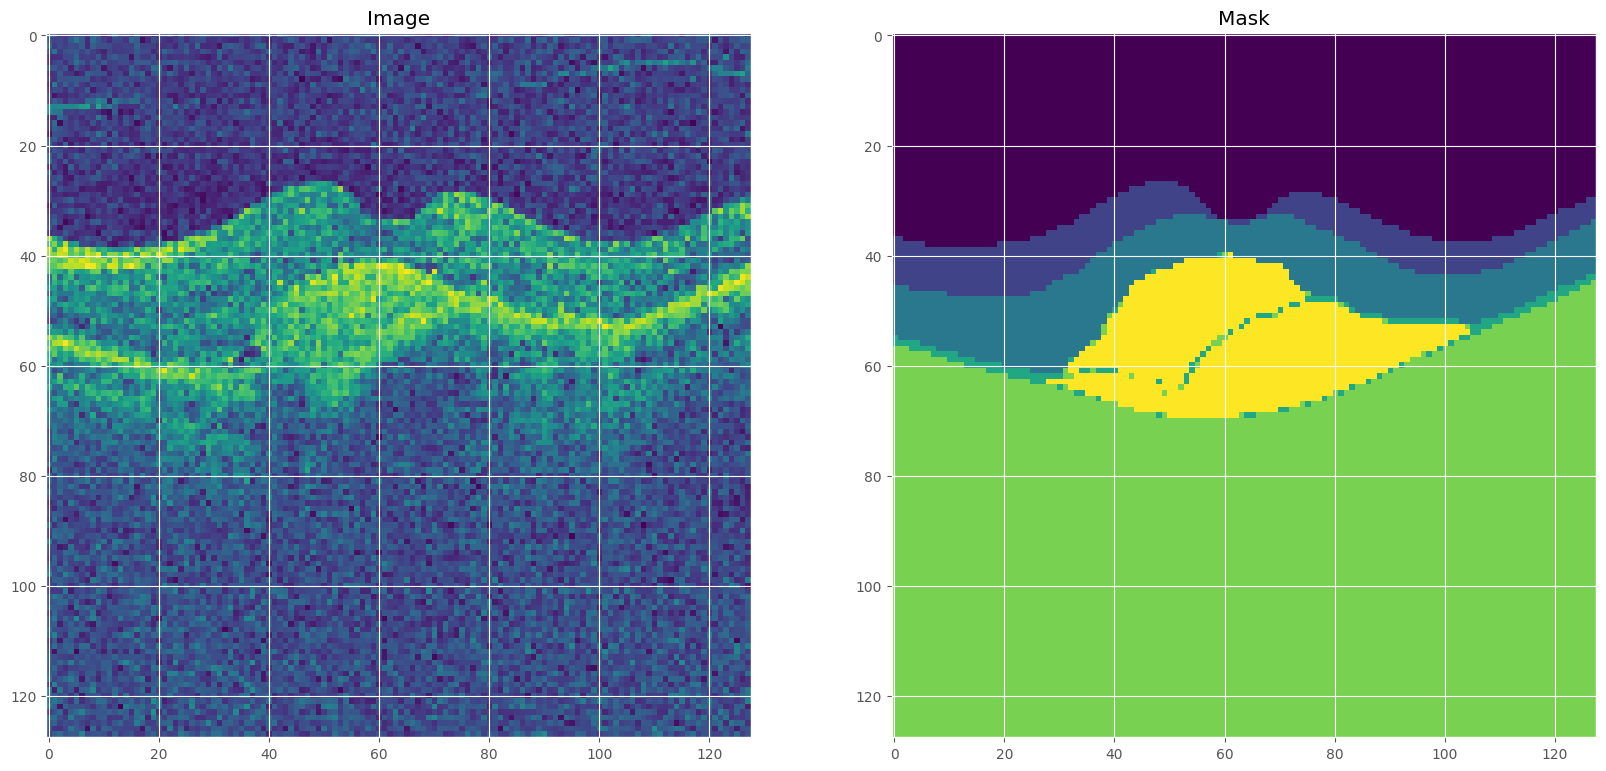

In [ ]:
import random
#print random mask
def show_img_and_mask(img, mask):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,15))
    ax1.set_title("Image")
    ax1.imshow(img)
    ax2.set_title("Mask")
    ax2.imshow(mask)

def print_mask(mask):
  with np.printoptions(threshold=np.inf):
      print(mask)

def shape_info(images, masks):
    print(f"shape of images {images[0].shape}")
    print(f"num images : {len(images)}")
    print(f"shape of mask {masks[0].shape}")
    print(f"num mask : {len(masks)}")
    print(f"num_classes : {np.unique(masks)}")

shape_info(T_image_clahe, T_mask)

rand_num = random.randint(0, len(T_image))
show_img_and_mask(T_image[rand_num], T_mask[rand_num])
show_img_and_mask(T_image_clahe[rand_num], T_mask[rand_num])


##Label Encoder

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

'''
optional step: just ensuring that the classes are 0-5 consecutively and no number skipped
'''

#get the shape of train_masks, number, height, width
n, h, w = T_mask.shape
#reshape train mask to one single vector (n*im_height * im_width, 1)
T_masks_reshaped = T_mask.reshape(-1,1)
#encode target label values from 0 to n_classes-1
T_masks_reshaped_encoded = labelencoder.fit_transform(T_masks_reshaped)
#change back the shape to ensure no operlap between classes / skip number
T_masks_encoded_original_shape = T_masks_reshaped_encoded.reshape(n, h, w)
print(T_masks_reshaped.shape)
print(T_masks_encoded_original_shape.shape)
print(np.unique(T_masks_encoded_original_shape))

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(18612224, 1)
(1136, 128, 128)
[0 1 2 3 4 5]


###Merubah kelas


In [ ]:
train_images = np.expand_dims(T_image_clahe, axis = 3)
train_images = min_max_normalize_batch(train_images)
train_masks_input = np.expand_dims(T_masks_encoded_original_shape, axis=3)

print(f"shape of train_images : {train_images.shape}")
print(f"shape of train_masks_input : {train_masks_input.shape}")

shape of train_images : (1136, 128, 128, 1)
shape of train_masks_input : (1136, 128, 128, 1)


#Architecture

In [ ]:
def unet_model(input_shape, n_classes=6, im_height=128, im_width=128):
    from keras.models import Model
    from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose

    inputs = Input(input_shape)

    # Contracting path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model


#Tuner

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam

def run_experiment(images, masks, mode_name, output_csv='result.csv'):
    print(f"\n[INFO] Mode: {mode_name}")
    print(f"Original images shape: {images.shape}")
    print(f"Original masks shape:  {masks.shape}")

    # Step 1: Double split
    X1, X_test, y1, y_test = train_test_split(images, masks, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X1, y1, test_size=0.2, random_state=42)

    print(f"\n[INFO] After train-test split:")
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_val shape:   {X_val.shape}")
    print(f"y_val shape:   {y_val.shape}")
    print(f"X_test shape:  {X_test.shape}")
    print(f"y_test shape:  {y_test.shape}")

    # One-hot encoding for segmentation masks
    y_train_cat = to_categorical(y_train, num_classes=6)
    y_val_cat = to_categorical(y_val, num_classes=6)

    print(f"\n[INFO] After one-hot encoding:")
    print(f"y_train_cat shape: {y_train_cat.shape}")  # (samples, H, W, 6)
    print(f"y_val_cat shape:   {y_val_cat.shape}")

    # Model builder with HP tuning
    def model_builder(hp):
        hp_learning_rate = hp.Choice('learning_rate', [0.01, 0.001, 0.0001])
        hp_batch_size = hp.Choice('batch_size', [8, 16, 32])
        model = unet_model(input_shape=X_train.shape[1:])
        model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model

    # Tuner
    tuner = RandomSearch(
        model_builder,
        objective='val_accuracy',
        max_trials=9,
        directory='tuner_dir',
        project_name=f'unet_{mode_name}'
    )

    tuner.search(X_train, y_train_cat,
                 epochs=20,
                 validation_data=(X_val, y_val_cat),
                 verbose=0)

    # Collect tuning results
    trials = tuner.oracle.get_best_trials(num_trials=10)
    records = []
    for trial in trials:
        hp = trial.hyperparameters.values
        records.append({
        'mode': mode_name,
        'learning_rate': hp.get('learning_rate', 'N/A'),
        'batch_size': hp.get('batch_size', 'N/A'),
        'val_accuracy': trial.metrics.get_last_value('val_accuracy'),
        'val_loss': trial.metrics.get_last_value('val_loss')
        })

    # Save results
    df_result = pd.DataFrame(records)
    df_result.to_csv(output_csv, mode='a', index=False, header=not pd.io.common.file_exists(output_csv))

    return df_result, X_train, y_train_cat, X_val, y_val_cat, X_test, y_test


#Prepare dataset

In [ ]:
images_clahe = train_images

images_norm = np.expand_dims(T_image, axis = 3)
images_norm = min_max_normalize_batch(images_norm)
train_masks_input = np.expand_dims(T_masks_encoded_original_shape, axis=3)

print(f"shape of clahe_train_images : {images_clahe.shape}")
print(f"shape of non_train_images : {images_norm.shape}")
print(f"shape of train_masks_input : {train_masks_input.shape}")

shape of clahe_train_images : (1136, 128, 128, 1)
shape of non_train_images : (1136, 128, 128, 1)
shape of train_masks_input : (1136, 128, 128, 1)


#Run Tuner

In [ ]:
df_clahe, X_train_clahe, y_train_cat_clahe, X_val_clahe, y_val_cat_clahe, X_test_clahe, y_test_clahe = run_experiment(images_clahe, train_masks_input, mode_name='CLAHE1', output_csv='hasil_tuning.csv')
df_norm, X_train_non, y_train_cat_non, X_val_non, y_val_cat_non, X_test_non, y_test_non = run_experiment(images_norm, train_masks_input, mode_name='Non_CLAHE1', output_csv='hasil_tuning.csv')


[INFO] Mode: CLAHE1
Original images shape: (1136, 128, 128, 1)
Original masks shape:  (1136, 128, 128, 1)

[INFO] After train-test split:
X_train shape: (817, 128, 128, 1)
y_train shape: (817, 128, 128, 1)
X_val shape:   (205, 128, 128, 1)
y_val shape:   (205, 128, 128, 1)
X_test shape:  (114, 128, 128, 1)
y_test shape:  (114, 128, 128, 1)

[INFO] After one-hot encoding:
y_train_cat shape: (817, 128, 128, 6)
y_val_cat shape:   (205, 128, 128, 6)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 1))
  warnings.warn(msg)



[INFO] Mode: Non_CLAHE1
Original images shape: (1136, 128, 128, 1)
Original masks shape:  (1136, 128, 128, 1)

[INFO] After train-test split:
X_train shape: (817, 128, 128, 1)
y_train shape: (817, 128, 128, 1)
X_val shape:   (205, 128, 128, 1)
y_val shape:   (205, 128, 128, 1)
X_test shape:  (114, 128, 128, 1)
y_test shape:  (114, 128, 128, 1)

[INFO] After one-hot encoding:
y_train_cat shape: (817, 128, 128, 6)
y_val_cat shape:   (205, 128, 128, 6)


/tmp/ipython-input-32-1369115016.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_per_mode = df.groupby('mode').apply(lambda g: g.loc[g['val_accuracy'].idxmax()]).reset_index(drop=True)
/tmp/ipython-input-32-1369115016.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=best_per_mode, x='mode', y='val_accuracy', palette='viridis')


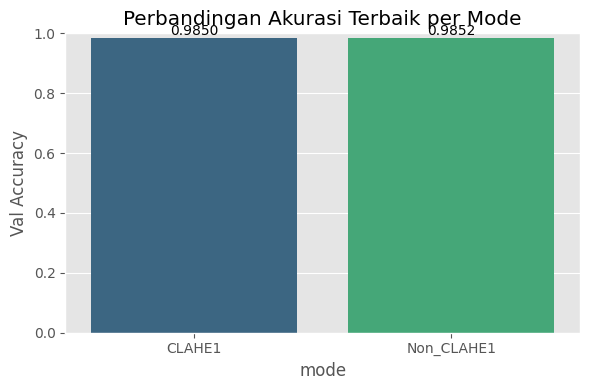

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load hasil tuning
df = pd.read_csv('hasil_tuning.csv')

# Ambil kombinasi terbaik tiap mode
best_per_mode = df.groupby('mode').apply(lambda g: g.loc[g['val_accuracy'].idxmax()]).reset_index(drop=True)

# Plot perbandingan akurasi terbaik
plt.figure(figsize=(6, 4))
sns.barplot(data=best_per_mode, x='mode', y='val_accuracy', palette='viridis')
plt.title("Perbandingan Akurasi Terbaik per Mode")
plt.ylabel("Val Accuracy")
plt.ylim(0, 1)
for index, row in best_per_mode.iterrows():
    plt.text(index, row['val_accuracy'] + 0.01, f"{row['val_accuracy']:.4f}", ha='center')
plt.tight_layout()
plt.show()


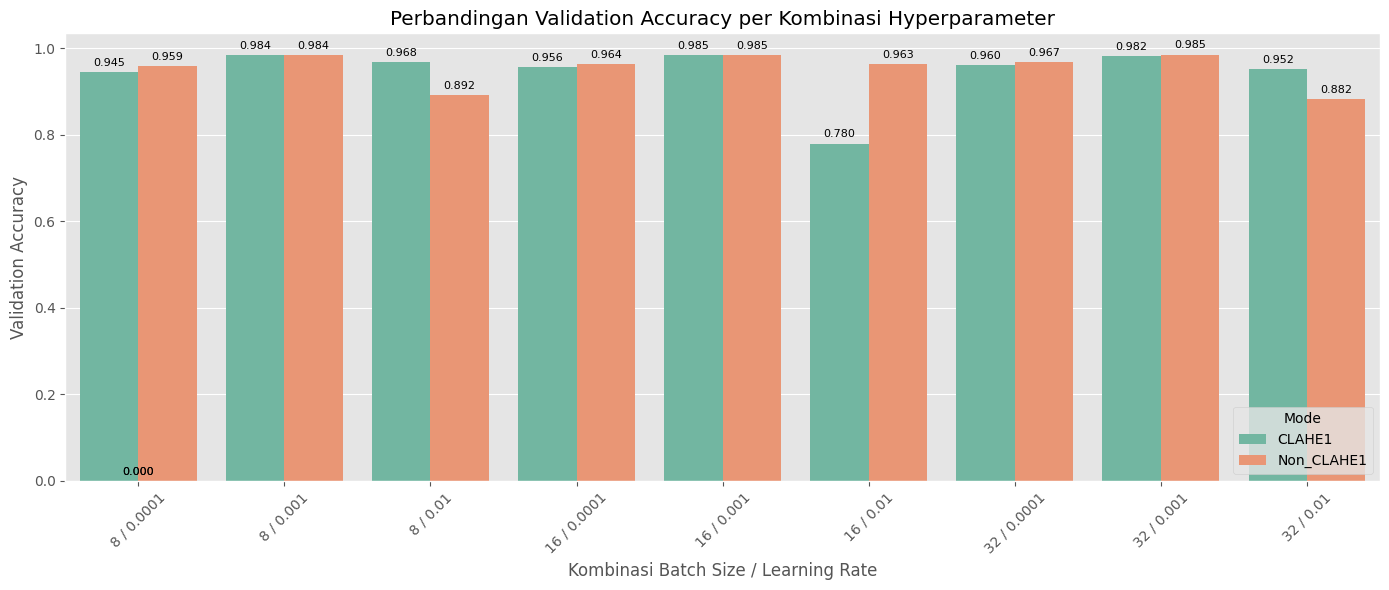

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load hasil tuning
df = pd.read_csv('hasil_tuning.csv')

# Buat kolom kombinasi untuk visualisasi
df['kombinasi'] = df.apply(lambda row: f"{int(row['batch_size'])} / {row['learning_rate']}", axis=1)

# Urutkan kombinasi agar lebih terstruktur (misalnya: batch_size kecil ke besar, learning_rate besar ke kecil)
df['batch_size'] = df['batch_size'].astype(int)
df['learning_rate'] = df['learning_rate'].astype(str)

# Urutkan dataframe
df_sorted = df.sort_values(by=['batch_size', 'learning_rate'])

# Buat plot bar
plt.figure(figsize=(14, 6))
barplot = sns.barplot(data=df_sorted, x='kombinasi', y='val_accuracy', hue='mode', palette='Set2')

# Tambahkan nilai di atas bar
for p in barplot.patches:
    height = p.get_height()
    if not pd.isna(height):
        barplot.annotate(f'{height:.3f}', (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='bottom', fontsize=8, color='black', xytext=(0, 3),
                         textcoords='offset points')

plt.title('Perbandingan Validation Accuracy per Kombinasi Hyperparameter')
plt.xlabel('Kombinasi Batch Size / Learning Rate')
plt.ylabel('Validation Accuracy')
plt.xticks(rotation=45)
plt.legend(title='Mode')
plt.tight_layout()
plt.show()


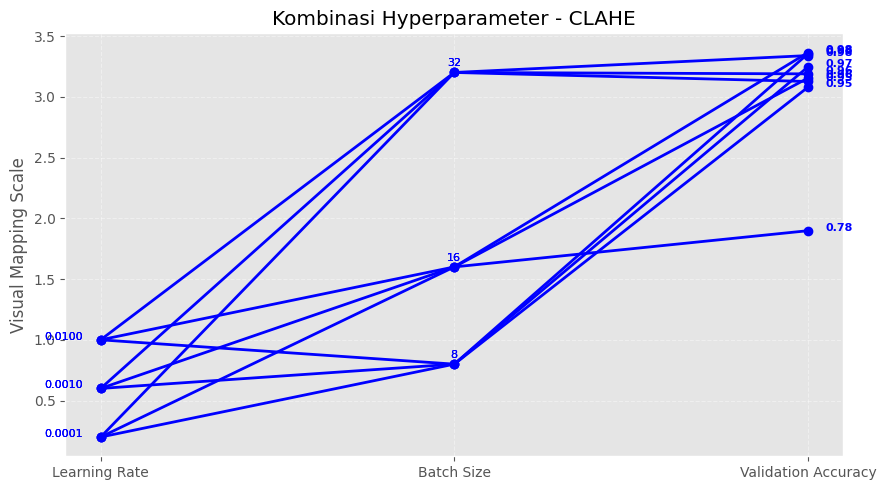

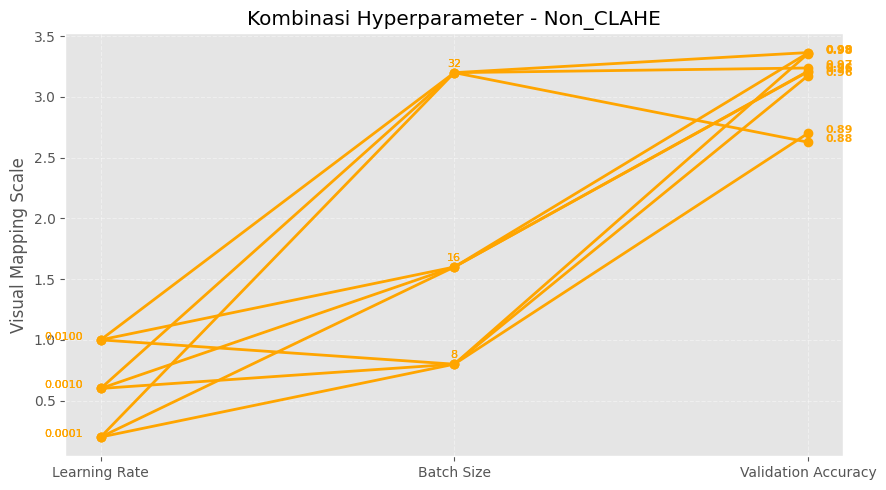

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data tuning
df = pd.read_csv('hasil_tuning.csv')

# Pastikan tipe data
df['batch_size'] = df['batch_size'].astype(float)
df['val_accuracy'] = df['val_accuracy'].astype(float)
df['learning_rate'] = df['learning_rate'].astype(float)

# Skala visualisasi (disesuaikan agar terlihat proporsional)
df['lr_scaled'] = df['learning_rate'].map({0.01: 1.0, 0.001: 0.6, 0.0001: 0.2})
df['bs_scaled'] = df['batch_size'] / 10
df['acc_mapped'] = (df['val_accuracy'] - 0.85) * 7.14 + 2.4  # mapping semi-linear

# Fungsi plotting
def plot_hyperparameter_flow(df_mode, color, label):
    fig, ax = plt.subplots(figsize=(9, 5))
    for _, row in df_mode.iterrows():
        if pd.isnull(row[['lr_scaled', 'bs_scaled', 'acc_mapped']]).any():
            continue  # skip baris yang tidak lengkap

        ax.plot([0, 1, 2],
                [row['lr_scaled'], row['bs_scaled'], row['acc_mapped']],
                color=color, linewidth=2, marker='o')

        # Tambahkan label
        ax.text(-0.05, row['lr_scaled'], f"{row['learning_rate']:.4f}", ha='right', fontsize=8, color=color)
        ax.text(1, row['bs_scaled'] + 0.05, f"{int(row['batch_size'])}", ha='center', fontsize=8, color=color)
        ax.text(2.05, row['acc_mapped'], f"{row['val_accuracy']:.2f}", ha='left', fontsize=8, fontweight='bold', color=color)

    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['Learning Rate', 'Batch Size', 'Validation Accuracy'])
    ax.set_ylabel('Visual Mapping Scale')
    ax.set_title(f'Kombinasi Hyperparameter - {label}')
    ax.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

# Filter per mode
df_clahe = df[df['mode'] == 'CLAHE1']
df_non_clahe = df[df['mode'] == 'Non_CLAHE1']

# Plot masing-masing
plot_hyperparameter_flow(df_clahe, color='blue', label='CLAHE')
plot_hyperparameter_flow(df_non_clahe, color='orange', label='Non_CLAHE')


#Retrain Model

In [ ]:
import pandas as pd
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model

# 1. Load hasil tuning
df = pd.read_csv('hasil_tuning.csv')

# 2. Ambil kombinasi terbaik untuk CLAHE & Non_CLAHE
best_clahe = df[df['mode'] == 'CLAHE1'].sort_values('val_accuracy', ascending=False).iloc[0]
best_non = df[df['mode'] == 'Non_CLAHE1'].sort_values('val_accuracy', ascending=False).iloc[0]

# 3. Fungsi retrain dengan hyperparameter terbaik
def retrain_best_model(mode, best_row, X_train, y_train, X_val, y_val, model_path):
    print(f"[INFO] Retraining model untuk mode: {mode}")
    print(f"Learning rate: {best_row['learning_rate']}, Batch size: {best_row['batch_size']}")

    model = unet_model(input_shape=X_train.shape[1:], n_classes=6)
    model.compile(
        optimizer=Adam(learning_rate=best_row['learning_rate']),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            dice_coefficient,
            MeanIoUCustom(num_classes=6)
        ]
    )

    checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, verbose=1)
    earlystop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=int(best_row['batch_size']),
        epochs=50,
        callbacks=[checkpoint, earlystop],
        verbose=1
    )

    print(f"[{mode}] Model terbaik disimpan ke: {model_path}")
    return model, history

# 4. Retrain model CLAHE
model_clahe, history_clahe = retrain_best_model(
    mode='CLAHE1',
    best_row=best_clahe,
    X_train=X_train_clahe,
    y_train=y_train_cat_clahe,
    X_val=X_val_clahe,
    y_val=y_val_cat_clahe,
    model_path='best_model_clahe.h5'
)

# 5. Retrain model Non_CLAHE
model_non, history_non = retrain_best_model(
    mode='Non_CLAHE1',
    best_row=best_non,
    X_train=X_train_non,
    y_train=y_train_cat_non,
    X_val=X_val_non,
    y_val=y_val_cat_non,
    model_path='best_model_non_clahe.h5'
)


[INFO] Retraining model untuk mode: CLAHE1
Learning rate: 0.001, Batch size: 16
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_82']
Received: inputs=Tensor(shape=(None, 128, 128, 1))
  warnings.warn(msg)


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.5671 - dice_coefficient: 0.1878 - loss: 1.3536 - mean_iou: 0.1749
Epoch 1: val_accuracy improved from -inf to 0.84269, saving model to best_model_clahe.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 37s 399ms/step - accuracy: 0.5702 - dice_coefficient: 0.1894 - loss: 1.3468 - mean_iou: 0.1767 - val_accuracy: 0.8427 - val_dice_coefficient: 0.3836 - val_loss: 0.6475 - val_mean_iou: 0.3445
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9031 - dice_coefficient: 0.4816 - loss: 0.3330 - mean_iou: 0.4572
Epoch 2: val_accuracy improved from 0.84269 to 0.93239, saving model to best_model_clahe.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.9034 - dice_coefficient: 0.4825 - loss: 0.3318 - mean_iou: 0.4579 - val_accuracy: 0.9324 - val_dice_coefficient: 0.5842 - val_loss: 0.2117 - val_mean_iou: 0.5373
Epoch 3/50
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9427 - dice_coefficient: 0.6346 - loss: 0.1667 - mean_iou: 0.5984
Epoch 3: val_accuracy improved from 0.93239 to 0.93478, saving model to best_model_clahe.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9429 - dice_coefficient: 0.6354 - loss: 0.1660 - mean_iou: 0.5993 - val_accuracy: 0.9348 - val_dice_coefficient: 0.6256 - val_loss: 0.1859 - val_mean_iou: 0.5832
Epoch 4/50
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9556 - dice_coefficient: 0.6954 - loss: 0.1212 - mean_iou: 0.6680
Epoch 4: val_accuracy improved from 0.93478 to 0.95990, saving model to best_model_clahe.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9557 - dice_coefficient: 0.6959 - loss: 0.1210 - mean_iou: 0.6687 - val_accuracy: 0.9599 - val_dice_coefficient: 0.7149 - val_loss: 0.1084 - val_mean_iou: 0.6900
Epoch 5/50
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9638 - dice_coefficient: 0.7423 - loss: 0.0989 - mean_iou: 0.7201
Epoch 5: val_accuracy improved from 0.95990 to 0.96976, saving model to best_model_clahe.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9639 - dice_coefficient: 0.7426 - loss: 0.0987 - mean_iou: 0.7205 - val_accuracy: 0.9698 - val_dice_coefficient: 0.7589 - val_loss: 0.0844 - val_mean_iou: 0.7505
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9662 - dice_coefficient: 0.7609 - loss: 0.0921 - mean_iou: 0.7376
Epoch 6: val_accuracy did not improve from 0.96976
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9663 - dice_coefficient: 0.7611 - loss: 0.0920 - mean_iou: 0.7378 - val_accuracy: 0.9619 - val_dice_coefficient: 0.7396 - val_loss: 0.1037 - val_mean_iou: 0.7160
Epoch 7/50
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9707 - dice_coefficient: 0.7846 - loss: 0.0807 - mean_iou: 0.7616
Epoch 7: val_accuracy did not improve from 0.96976
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9707 - dice_coefficient: 0.7848 - loss: 0.0806 - mean_iou: 0.7619 - val_accuracy: 0.9642 - val_dice_coefficient: 0.7496 - val_loss: 0.0980 - val_mean_

52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9740 - dice_coefficient: 0.8018 - loss: 0.0715 - mean_iou: 0.7794 - val_accuracy: 0.9744 - val_dice_coefficient: 0.8017 - val_loss: 0.0695 - val_mean_iou: 0.7797
Epoch 9/50
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9764 - dice_coefficient: 0.8122 - loss: 0.0648 - mean_iou: 0.7881
Epoch 9: val_accuracy improved from 0.97443 to 0.97595, saving model to best_model_clahe.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9765 - dice_coefficient: 0.8123 - loss: 0.0648 - mean_iou: 0.7883 - val_accuracy: 0.9760 - val_dice_coefficient: 0.8087 - val_loss: 0.0666 - val_mean_iou: 0.7871
Epoch 10/50
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9786 - dice_coefficient: 0.8267 - loss: 0.0590 - mean_iou: 0.8039
Epoch 10: val_accuracy did not improve from 0.97595
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9786 - dice_coefficient: 0.8267 - loss: 0.0590 - mean_iou: 0.8040 - val_accuracy: 0.9748 - val_dice_coefficient: 0.8066 - val_loss: 0.0712 - val_mean_iou: 0.7855
Epoch 11/50
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9795 - dice_coefficient: 0.8349 - loss: 0.0571 - mean_iou: 0.8122
Epoch 11: val_accuracy improved from 0.97595 to 0.97720, saving model to best_model_clahe.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9795 - dice_coefficient: 0.8349 - loss: 0.0571 - mean_iou: 0.8123 - val_accuracy: 0.9772 - val_dice_coefficient: 0.8235 - val_loss: 0.0641 - val_mean_iou: 0.7987
Epoch 12/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9801 - dice_coefficient: 0.8364 - loss: 0.0550 - mean_iou: 0.8145
Epoch 12: val_accuracy improved from 0.97720 to 0.98128, saving model to best_model_clahe.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.9801 - dice_coefficient: 0.8365 - loss: 0.0550 - mean_iou: 0.8145 - val_accuracy: 0.9813 - val_dice_coefficient: 0.8473 - val_loss: 0.0518 - val_mean_iou: 0.8249
Epoch 13/50
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9815 - dice_coefficient: 0.8468 - loss: 0.0507 - mean_iou: 0.8230
Epoch 13: val_accuracy improved from 0.98128 to 0.98251, saving model to best_model_clahe.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9815 - dice_coefficient: 0.8468 - loss: 0.0507 - mean_iou: 0.8231 - val_accuracy: 0.9825 - val_dice_coefficient: 0.8426 - val_loss: 0.0490 - val_mean_iou: 0.8307
Epoch 14/50
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9818 - dice_coefficient: 0.8465 - loss: 0.0502 - mean_iou: 0.8248
Epoch 14: val_accuracy did not improve from 0.98251
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9818 - dice_coefficient: 0.8466 - loss: 0.0502 - mean_iou: 0.8249 - val_accuracy: 0.9824 - val_dice_coefficient: 0.8560 - val_loss: 0.0492 - val_mean_iou: 0.8352
Epoch 15/50
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9826 - dice_coefficient: 0.8525 - loss: 0.0481 - mean_iou: 0.8315
Epoch 15: val_accuracy did not improve from 0.98251
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9826 - dice_coefficient: 0.8525 - loss: 0.0481 - mean_iou: 0.8315 - val_accuracy: 0.9785 - val_dice_coefficient: 0.8362 - val_loss: 0.0613 - val_m

52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9828 - dice_coefficient: 0.8568 - loss: 0.0479 - mean_iou: 0.8371 - val_accuracy: 0.9846 - val_dice_coefficient: 0.8665 - val_loss: 0.0425 - val_mean_iou: 0.8484
Epoch 18/50
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9833 - dice_coefficient: 0.8597 - loss: 0.0468 - mean_iou: 0.8381
Epoch 18: val_accuracy did not improve from 0.98459
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9833 - dice_coefficient: 0.8597 - loss: 0.0467 - mean_iou: 0.8382 - val_accuracy: 0.9838 - val_dice_coefficient: 0.8573 - val_loss: 0.0457 - val_mean_iou: 0.8429
Epoch 19/50
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9837 - dice_coefficient: 0.8634 - loss: 0.0448 - mean_iou: 0.8426
Epoch 19: val_accuracy improved from 0.98459 to 0.98560, saving model to best_model_clahe.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9837 - dice_coefficient: 0.8634 - loss: 0.0447 - mean_iou: 0.8427 - val_accuracy: 0.9856 - val_dice_coefficient: 0.8720 - val_loss: 0.0395 - val_mean_iou: 0.8557
Epoch 20/50
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9847 - dice_coefficient: 0.8690 - loss: 0.0417 - mean_iou: 0.8473
Epoch 20: val_accuracy improved from 0.98560 to 0.98591, saving model to best_model_clahe.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9847 - dice_coefficient: 0.8690 - loss: 0.0417 - mean_iou: 0.8473 - val_accuracy: 0.9859 - val_dice_coefficient: 0.8725 - val_loss: 0.0388 - val_mean_iou: 0.8569
Epoch 21/50
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9844 - dice_coefficient: 0.8690 - loss: 0.0435 - mean_iou: 0.8486
Epoch 21: val_accuracy did not improve from 0.98591
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9844 - dice_coefficient: 0.8690 - loss: 0.0434 - mean_iou: 0.8487 - val_accuracy: 0.9856 - val_dice_coefficient: 0.8672 - val_loss: 0.0395 - val_mean_iou: 0.8520
Epoch 22/50
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9847 - dice_coefficient: 0.8682 - loss: 0.0417 - mean_iou: 0.8475
Epoch 22: val_accuracy did not improve from 0.98591
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9847 - dice_coefficient: 0.8683 - loss: 0.0417 - mean_iou: 0.8476 - val_accuracy: 0.9851 - val_dice_coefficient: 0.8636 - val_loss: 0.0430 - val_m

52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9852 - dice_coefficient: 0.8732 - loss: 0.0404 - mean_iou: 0.8521 - val_accuracy: 0.9860 - val_dice_coefficient: 0.8788 - val_loss: 0.0389 - val_mean_iou: 0.8591
Epoch 26/50
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9859 - dice_coefficient: 0.8772 - loss: 0.0382 - mean_iou: 0.8558
Epoch 26: val_accuracy improved from 0.98596 to 0.98630, saving model to best_model_clahe.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9859 - dice_coefficient: 0.8772 - loss: 0.0382 - mean_iou: 0.8559 - val_accuracy: 0.9863 - val_dice_coefficient: 0.8794 - val_loss: 0.0374 - val_mean_iou: 0.8606
Epoch 27/50
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9857 - dice_coefficient: 0.8753 - loss: 0.0387 - mean_iou: 0.8551
Epoch 27: val_accuracy improved from 0.98630 to 0.98702, saving model to best_model_clahe.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9857 - dice_coefficient: 0.8753 - loss: 0.0387 - mean_iou: 0.8551 - val_accuracy: 0.9870 - val_dice_coefficient: 0.8807 - val_loss: 0.0355 - val_mean_iou: 0.8648
Epoch 28/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9864 - dice_coefficient: 0.8807 - loss: 0.0370 - mean_iou: 0.8601
Epoch 28: val_accuracy did not improve from 0.98702
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9864 - dice_coefficient: 0.8807 - loss: 0.0370 - mean_iou: 0.8601 - val_accuracy: 0.9864 - val_dice_coefficient: 0.8815 - val_loss: 0.0378 - val_mean_iou: 0.8607
Epoch 29/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9859 - dice_coefficient: 0.8778 - loss: 0.0382 - mean_iou: 0.8565
Epoch 29: val_accuracy improved from 0.98702 to 0.98731, saving model to best_model_clahe.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9859 - dice_coefficient: 0.8778 - loss: 0.0382 - mean_iou: 0.8565 - val_accuracy: 0.9873 - val_dice_coefficient: 0.8862 - val_loss: 0.0342 - val_mean_iou: 0.8667
Epoch 30/50
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9860 - dice_coefficient: 0.8798 - loss: 0.0380 - mean_iou: 0.8581
Epoch 30: val_accuracy did not improve from 0.98731
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9860 - dice_coefficient: 0.8798 - loss: 0.0380 - mean_iou: 0.8581 - val_accuracy: 0.9868 - val_dice_coefficient: 0.8799 - val_loss: 0.0366 - val_mean_iou: 0.8625
Epoch 31/50
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9864 - dice_coefficient: 0.8822 - loss: 0.0367 - mean_iou: 0.8622
Epoch 31: val_accuracy improved from 0.98731 to 0.98732, saving model to best_model_clahe.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.9864 - dice_coefficient: 0.8822 - loss: 0.0367 - mean_iou: 0.8623 - val_accuracy: 0.9873 - val_dice_coefficient: 0.8876 - val_loss: 0.0343 - val_mean_iou: 0.8669
Epoch 32/50
50/52 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9861 - dice_coefficient: 0.8808 - loss: 0.0377 - mean_iou: 0.8590
Epoch 32: val_accuracy did not improve from 0.98732
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9861 - dice_coefficient: 0.8809 - loss: 0.0376 - mean_iou: 0.8592 - val_accuracy: 0.9858 - val_dice_coefficient: 0.8803 - val_loss: 0.0390 - val_mean_iou: 0.8565
Epoch 33/50
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9860 - dice_coefficient: 0.8803 - loss: 0.0379 - mean_iou: 0.8597
Epoch 33: val_accuracy did not improve from 0.98732
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9860 - dice_coefficient: 0.8803 - loss: 0.0379 - mean_iou: 0.8597 - val_accuracy: 0.9854 - val_dice_coefficient: 0.8736 - val_loss: 0.0422 - val_m

52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9868 - dice_coefficient: 0.8839 - loss: 0.0356 - mean_iou: 0.8643 - val_accuracy: 0.9876 - val_dice_coefficient: 0.8883 - val_loss: 0.0338 - val_mean_iou: 0.8689
Epoch 35/50
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9872 - dice_coefficient: 0.8880 - loss: 0.0341 - mean_iou: 0.8670
Epoch 35: val_accuracy improved from 0.98756 to 0.98778, saving model to best_model_clahe.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9872 - dice_coefficient: 0.8879 - loss: 0.0342 - mean_iou: 0.8670 - val_accuracy: 0.9878 - val_dice_coefficient: 0.8864 - val_loss: 0.0332 - val_mean_iou: 0.8712
Epoch 36/50
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9872 - dice_coefficient: 0.8868 - loss: 0.0342 - mean_iou: 0.8667
Epoch 36: val_accuracy did not improve from 0.98778
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9872 - dice_coefficient: 0.8868 - loss: 0.0342 - mean_iou: 0.8667 - val_accuracy: 0.9867 - val_dice_coefficient: 0.8853 - val_loss: 0.0368 - val_mean_iou: 0.8629
Epoch 37/50
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9867 - dice_coefficient: 0.8844 - loss: 0.0359 - mean_iou: 0.8638
Epoch 37: val_accuracy did not improve from 0.98778
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9867 - dice_coefficient: 0.8844 - loss: 0.0358 - mean_iou: 0.8638 - val_accuracy: 0.9875 - val_dice_coefficient: 0.8893 - val_loss: 0.0341 - val_m

52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9874 - dice_coefficient: 0.8893 - loss: 0.0334 - mean_iou: 0.8687 - val_accuracy: 0.9879 - val_dice_coefficient: 0.8883 - val_loss: 0.0330 - val_mean_iou: 0.8727
Epoch 40/50
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9872 - dice_coefficient: 0.8881 - loss: 0.0341 - mean_iou: 0.8684
Epoch 40: val_accuracy did not improve from 0.98792
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9872 - dice_coefficient: 0.8882 - loss: 0.0341 - mean_iou: 0.8685 - val_accuracy: 0.9878 - val_dice_coefficient: 0.8910 - val_loss: 0.0332 - val_mean_iou: 0.8720
Epoch 41/50
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9877 - dice_coefficient: 0.8916 - loss: 0.0327 - mean_iou: 0.8719
Epoch 41: val_accuracy improved from 0.98792 to 0.98819, saving model to best_model_clahe.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9877 - dice_coefficient: 0.8915 - loss: 0.0327 - mean_iou: 0.8718 - val_accuracy: 0.9882 - val_dice_coefficient: 0.8951 - val_loss: 0.0315 - val_mean_iou: 0.8742
Epoch 42/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9877 - dice_coefficient: 0.8914 - loss: 0.0325 - mean_iou: 0.8706
Epoch 42: val_accuracy improved from 0.98819 to 0.98825, saving model to best_model_clahe.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.9877 - dice_coefficient: 0.8914 - loss: 0.0325 - mean_iou: 0.8706 - val_accuracy: 0.9882 - val_dice_coefficient: 0.8953 - val_loss: 0.0319 - val_mean_iou: 0.8746
Epoch 43/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9880 - dice_coefficient: 0.8943 - loss: 0.0317 - mean_iou: 0.8729
Epoch 43: val_accuracy improved from 0.98825 to 0.98850, saving model to best_model_clahe.h5


52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.9880 - dice_coefficient: 0.8942 - loss: 0.0317 - mean_iou: 0.8729 - val_accuracy: 0.9885 - val_dice_coefficient: 0.8951 - val_loss: 0.0308 - val_mean_iou: 0.8761
Epoch 44/50
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9879 - dice_coefficient: 0.8935 - loss: 0.0319 - mean_iou: 0.8728
Epoch 44: val_accuracy did not improve from 0.98850
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.9879 - dice_coefficient: 0.8934 - loss: 0.0319 - mean_iou: 0.8728 - val_accuracy: 0.9868 - val_dice_coefficient: 0.8882 - val_loss: 0.0350 - val_mean_iou: 0.8664
Epoch 45/50
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9871 - dice_coefficient: 0.8895 - loss: 0.0347 - mean_iou: 0.8685
Epoch 45: val_accuracy did not improve from 0.98850
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9871 - dice_coefficient: 0.8896 - loss: 0.0346 - mean_iou: 0.8686 - val_accuracy: 0.9885 - val_dice_coefficient: 0.8961 - val_loss: 0.0308 - val_m

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_123']
Received: inputs=Tensor(shape=(None, 128, 128, 1))
  warnings.warn(msg)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.2379 - dice_coefficient: 0.1344 - loss: 1.6916 - mean_iou: 0.0784
Epoch 1: val_accuracy improved from -inf to 0.83257, saving model to best_model_non_clahe.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 37s 766ms/step - accuracy: 0.2448 - dice_coefficient: 0.1360 - loss: 1.6831 - mean_iou: 0.0807 - val_accuracy: 0.8326 - val_dice_coefficient: 0.3290 - val_loss: 0.5902 - val_mean_iou: 0.2857
Epoch 2/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8319 - dice_coefficient: 0.3852 - loss: 0.4657 - mean_iou: 0.2879
Epoch 2: val_accuracy improved from 0.83257 to 0.86825, saving model to best_model_non_clahe.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - accuracy: 0.8325 - dice_coefficient: 0.3865 - loss: 0.4612 - mean_iou: 0.2886 - val_accuracy: 0.8683 - val_dice_coefficient: 0.4182 - val_loss: 0.3398 - val_mean_iou: 0.3522
Epoch 3/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8815 - dice_coefficient: 0.4373 - loss: 0.3161 - mean_iou: 0.3756
Epoch 3: val_accuracy improved from 0.86825 to 0.91255, saving model to best_model_non_clahe.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.8827 - dice_coefficient: 0.4385 - loss: 0.3145 - mean_iou: 0.3776 - val_accuracy: 0.9125 - val_dice_coefficient: 0.4861 - val_loss: 0.2474 - val_mean_iou: 0.4356
Epoch 4/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9332 - dice_coefficient: 0.5595 - loss: 0.1963 - mean_iou: 0.5269
Epoch 4: val_accuracy improved from 0.91255 to 0.94454, saving model to best_model_non_clahe.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.9336 - dice_coefficient: 0.5626 - loss: 0.1948 - mean_iou: 0.5300 - val_accuracy: 0.9445 - val_dice_coefficient: 0.6420 - val_loss: 0.1506 - val_mean_iou: 0.6242
Epoch 5/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9503 - dice_coefficient: 0.6675 - loss: 0.1330 - mean_iou: 0.6310
Epoch 5: val_accuracy improved from 0.94454 to 0.96032, saving model to best_model_non_clahe.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9504 - dice_coefficient: 0.6682 - loss: 0.1326 - mean_iou: 0.6318 - val_accuracy: 0.9603 - val_dice_coefficient: 0.7008 - val_loss: 0.1043 - val_mean_iou: 0.6811
Epoch 6/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9569 - dice_coefficient: 0.7034 - loss: 0.1129 - mean_iou: 0.6743
Epoch 6: val_accuracy improved from 0.96032 to 0.96462, saving model to best_model_non_clahe.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9570 - dice_coefficient: 0.7039 - loss: 0.1126 - mean_iou: 0.6751 - val_accuracy: 0.9646 - val_dice_coefficient: 0.7175 - val_loss: 0.0974 - val_mean_iou: 0.7276
Epoch 7/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9651 - dice_coefficient: 0.7326 - loss: 0.0959 - mean_iou: 0.7149
Epoch 7: val_accuracy improved from 0.96462 to 0.97015, saving model to best_model_non_clahe.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.9651 - dice_coefficient: 0.7333 - loss: 0.0958 - mean_iou: 0.7158 - val_accuracy: 0.9701 - val_dice_coefficient: 0.7681 - val_loss: 0.0815 - val_mean_iou: 0.7601
Epoch 8/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9685 - dice_coefficient: 0.7701 - loss: 0.0868 - mean_iou: 0.7494
Epoch 8: val_accuracy improved from 0.97015 to 0.97076, saving model to best_model_non_clahe.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9685 - dice_coefficient: 0.7702 - loss: 0.0868 - mean_iou: 0.7495 - val_accuracy: 0.9708 - val_dice_coefficient: 0.7714 - val_loss: 0.0799 - val_mean_iou: 0.7722
Epoch 9/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9700 - dice_coefficient: 0.7810 - loss: 0.0824 - mean_iou: 0.7598
Epoch 9: val_accuracy improved from 0.97076 to 0.97357, saving model to best_model_non_clahe.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.9701 - dice_coefficient: 0.7814 - loss: 0.0822 - mean_iou: 0.7602 - val_accuracy: 0.9736 - val_dice_coefficient: 0.7907 - val_loss: 0.0709 - val_mean_iou: 0.7843
Epoch 10/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9732 - dice_coefficient: 0.7984 - loss: 0.0741 - mean_iou: 0.7758
Epoch 10: val_accuracy improved from 0.97357 to 0.97641, saving model to best_model_non_clahe.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.9732 - dice_coefficient: 0.7986 - loss: 0.0741 - mean_iou: 0.7759 - val_accuracy: 0.9764 - val_dice_coefficient: 0.8063 - val_loss: 0.0646 - val_mean_iou: 0.7931
Epoch 11/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9754 - dice_coefficient: 0.8082 - loss: 0.0687 - mean_iou: 0.7865
Epoch 11: val_accuracy improved from 0.97641 to 0.97769, saving model to best_model_non_clahe.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.9754 - dice_coefficient: 0.8084 - loss: 0.0687 - mean_iou: 0.7866 - val_accuracy: 0.9777 - val_dice_coefficient: 0.8184 - val_loss: 0.0608 - val_mean_iou: 0.8074
Epoch 12/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9768 - dice_coefficient: 0.8198 - loss: 0.0649 - mean_iou: 0.7959
Epoch 12: val_accuracy improved from 0.97769 to 0.97824, saving model to best_model_non_clahe.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.9768 - dice_coefficient: 0.8198 - loss: 0.0649 - mean_iou: 0.7960 - val_accuracy: 0.9782 - val_dice_coefficient: 0.8233 - val_loss: 0.0605 - val_mean_iou: 0.8037
Epoch 13/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9776 - dice_coefficient: 0.8220 - loss: 0.0623 - mean_iou: 0.8000
Epoch 13: val_accuracy improved from 0.97824 to 0.98132, saving model to best_model_non_clahe.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9776 - dice_coefficient: 0.8222 - loss: 0.0622 - mean_iou: 0.8003 - val_accuracy: 0.9813 - val_dice_coefficient: 0.8343 - val_loss: 0.0523 - val_mean_iou: 0.8238
Epoch 14/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9797 - dice_coefficient: 0.8338 - loss: 0.0563 - mean_iou: 0.8105
Epoch 14: val_accuracy improved from 0.98132 to 0.98210, saving model to best_model_non_clahe.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9797 - dice_coefficient: 0.8340 - loss: 0.0564 - mean_iou: 0.8107 - val_accuracy: 0.9821 - val_dice_coefficient: 0.8420 - val_loss: 0.0496 - val_mean_iou: 0.8296
Epoch 15/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9806 - dice_coefficient: 0.8416 - loss: 0.0542 - mean_iou: 0.8193
Epoch 15: val_accuracy improved from 0.98210 to 0.98275, saving model to best_model_non_clahe.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.9806 - dice_coefficient: 0.8415 - loss: 0.0542 - mean_iou: 0.8192 - val_accuracy: 0.9828 - val_dice_coefficient: 0.8460 - val_loss: 0.0478 - val_mean_iou: 0.8348
Epoch 16/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9811 - dice_coefficient: 0.8452 - loss: 0.0528 - mean_iou: 0.8229
Epoch 16: val_accuracy improved from 0.98275 to 0.98277, saving model to best_model_non_clahe.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9811 - dice_coefficient: 0.8452 - loss: 0.0528 - mean_iou: 0.8229 - val_accuracy: 0.9828 - val_dice_coefficient: 0.8479 - val_loss: 0.0476 - val_mean_iou: 0.8334
Epoch 17/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9813 - dice_coefficient: 0.8462 - loss: 0.0523 - mean_iou: 0.8251
Epoch 17: val_accuracy improved from 0.98277 to 0.98301, saving model to best_model_non_clahe.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9813 - dice_coefficient: 0.8463 - loss: 0.0522 - mean_iou: 0.8252 - val_accuracy: 0.9830 - val_dice_coefficient: 0.8487 - val_loss: 0.0471 - val_mean_iou: 0.8385
Epoch 18/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9820 - dice_coefficient: 0.8496 - loss: 0.0502 - mean_iou: 0.8286
Epoch 18: val_accuracy improved from 0.98301 to 0.98356, saving model to best_model_non_clahe.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.9820 - dice_coefficient: 0.8498 - loss: 0.0502 - mean_iou: 0.8288 - val_accuracy: 0.9836 - val_dice_coefficient: 0.8539 - val_loss: 0.0454 - val_mean_iou: 0.8415
Epoch 19/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9823 - dice_coefficient: 0.8540 - loss: 0.0493 - mean_iou: 0.8326
Epoch 19: val_accuracy improved from 0.98356 to 0.98396, saving model to best_model_non_clahe.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.9824 - dice_coefficient: 0.8541 - loss: 0.0492 - mean_iou: 0.8326 - val_accuracy: 0.9840 - val_dice_coefficient: 0.8566 - val_loss: 0.0442 - val_mean_iou: 0.8430
Epoch 20/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9823 - dice_coefficient: 0.8532 - loss: 0.0501 - mean_iou: 0.8318
Epoch 20: val_accuracy improved from 0.98396 to 0.98453, saving model to best_model_non_clahe.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9824 - dice_coefficient: 0.8534 - loss: 0.0500 - mean_iou: 0.8320 - val_accuracy: 0.9845 - val_dice_coefficient: 0.8588 - val_loss: 0.0428 - val_mean_iou: 0.8443
Epoch 21/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9837 - dice_coefficient: 0.8601 - loss: 0.0456 - mean_iou: 0.8390
Epoch 21: val_accuracy improved from 0.98453 to 0.98544, saving model to best_model_non_clahe.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.9837 - dice_coefficient: 0.8602 - loss: 0.0456 - mean_iou: 0.8391 - val_accuracy: 0.9854 - val_dice_coefficient: 0.8650 - val_loss: 0.0404 - val_mean_iou: 0.8532
Epoch 22/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9841 - dice_coefficient: 0.8633 - loss: 0.0445 - mean_iou: 0.8417
Epoch 22: val_accuracy improved from 0.98544 to 0.98586, saving model to best_model_non_clahe.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.9841 - dice_coefficient: 0.8634 - loss: 0.0445 - mean_iou: 0.8418 - val_accuracy: 0.9859 - val_dice_coefficient: 0.8681 - val_loss: 0.0390 - val_mean_iou: 0.8556
Epoch 23/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9841 - dice_coefficient: 0.8662 - loss: 0.0443 - mean_iou: 0.8452
Epoch 23: val_accuracy did not improve from 0.98586
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.9841 - dice_coefficient: 0.8661 - loss: 0.0443 - mean_iou: 0.8452 - val_accuracy: 0.9857 - val_dice_coefficient: 0.8649 - val_loss: 0.0394 - val_mean_iou: 0.8548
Epoch 24/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9840 - dice_coefficient: 0.8637 - loss: 0.0447 - mean_iou: 0.8431
Epoch 24: val_accuracy did not improve from 0.98586
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.9840 - dice_coefficient: 0.8637 - loss: 0.0447 - mean_iou: 0.8431 - val_accuracy: 0.9858 - val_dice_coefficient: 0.8676 - val_loss: 0.0395 - val_m

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9847 - dice_coefficient: 0.8674 - loss: 0.0428 - mean_iou: 0.8475 - val_accuracy: 0.9860 - val_dice_coefficient: 0.8733 - val_loss: 0.0383 - val_mean_iou: 0.8584
Epoch 26/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9847 - dice_coefficient: 0.8705 - loss: 0.0425 - mean_iou: 0.8488
Epoch 26: val_accuracy did not improve from 0.98602
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.9847 - dice_coefficient: 0.8706 - loss: 0.0424 - mean_iou: 0.8489 - val_accuracy: 0.9857 - val_dice_coefficient: 0.8687 - val_loss: 0.0387 - val_mean_iou: 0.8541
Epoch 27/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9856 - dice_coefficient: 0.8753 - loss: 0.0399 - mean_iou: 0.8542
Epoch 27: val_accuracy did not improve from 0.98602
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9856 - dice_coefficient: 0.8752 - loss: 0.0400 - mean_iou: 0.8540 - val_accuracy: 0.9859 - val_dice_coefficient: 0.8700 - val_loss: 0.0384 - val_m

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9856 - dice_coefficient: 0.8736 - loss: 0.0397 - mean_iou: 0.8524 - val_accuracy: 0.9867 - val_dice_coefficient: 0.8757 - val_loss: 0.0363 - val_mean_iou: 0.8615
Epoch 29/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9855 - dice_coefficient: 0.8754 - loss: 0.0407 - mean_iou: 0.8544
Epoch 29: val_accuracy did not improve from 0.98670
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9855 - dice_coefficient: 0.8754 - loss: 0.0407 - mean_iou: 0.8544 - val_accuracy: 0.9856 - val_dice_coefficient: 0.8716 - val_loss: 0.0387 - val_mean_iou: 0.8553
Epoch 30/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9857 - dice_coefficient: 0.8772 - loss: 0.0395 - mean_iou: 0.8557
Epoch 30: val_accuracy did not improve from 0.98670
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.9857 - dice_coefficient: 0.8772 - loss: 0.0395 - mean_iou: 0.8556 - val_accuracy: 0.9866 - val_dice_coefficient: 0.8757 - val_loss: 0.0367 - val_m

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.9861 - dice_coefficient: 0.8787 - loss: 0.0382 - mean_iou: 0.8578 - val_accuracy: 0.9873 - val_dice_coefficient: 0.8825 - val_loss: 0.0346 - val_mean_iou: 0.8661
Epoch 32/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9861 - dice_coefficient: 0.8788 - loss: 0.0382 - mean_iou: 0.8568
Epoch 32: val_accuracy did not improve from 0.98729
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.9861 - dice_coefficient: 0.8789 - loss: 0.0382 - mean_iou: 0.8569 - val_accuracy: 0.9871 - val_dice_coefficient: 0.8812 - val_loss: 0.0348 - val_mean_iou: 0.8647
Epoch 33/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9863 - dice_coefficient: 0.8795 - loss: 0.0378 - mean_iou: 0.8578
Epoch 33: val_accuracy improved from 0.98729 to 0.98759, saving model to best_model_non_clahe.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9863 - dice_coefficient: 0.8795 - loss: 0.0378 - mean_iou: 0.8579 - val_accuracy: 0.9876 - val_dice_coefficient: 0.8832 - val_loss: 0.0337 - val_mean_iou: 0.8686
Epoch 34/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9865 - dice_coefficient: 0.8842 - loss: 0.0371 - mean_iou: 0.8633
Epoch 34: val_accuracy did not improve from 0.98759
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9865 - dice_coefficient: 0.8841 - loss: 0.0371 - mean_iou: 0.8632 - val_accuracy: 0.9875 - val_dice_coefficient: 0.8824 - val_loss: 0.0340 - val_mean_iou: 0.8672
Epoch 35/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9868 - dice_coefficient: 0.8835 - loss: 0.0359 - mean_iou: 0.8623
Epoch 35: val_accuracy improved from 0.98759 to 0.98768, saving model to best_model_non_clahe.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9868 - dice_coefficient: 0.8834 - loss: 0.0360 - mean_iou: 0.8622 - val_accuracy: 0.9877 - val_dice_coefficient: 0.8850 - val_loss: 0.0333 - val_mean_iou: 0.8695
Epoch 36/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9861 - dice_coefficient: 0.8805 - loss: 0.0384 - mean_iou: 0.8600
Epoch 36: val_accuracy did not improve from 0.98768
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.9861 - dice_coefficient: 0.8807 - loss: 0.0383 - mean_iou: 0.8602 - val_accuracy: 0.9874 - val_dice_coefficient: 0.8838 - val_loss: 0.0337 - val_mean_iou: 0.8676
Epoch 37/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9865 - dice_coefficient: 0.8844 - loss: 0.0369 - mean_iou: 0.8627
Epoch 37: val_accuracy did not improve from 0.98768
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.9865 - dice_coefficient: 0.8844 - loss: 0.0368 - mean_iou: 0.8627 - val_accuracy: 0.9874 - val_dice_coefficient: 0.8828 - val_loss: 0.0337 - val_m

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9869 - dice_coefficient: 0.8861 - loss: 0.0355 - mean_iou: 0.8651 - val_accuracy: 0.9877 - val_dice_coefficient: 0.8837 - val_loss: 0.0333 - val_mean_iou: 0.8703
Epoch 39/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9869 - dice_coefficient: 0.8848 - loss: 0.0355 - mean_iou: 0.8633
Epoch 39: val_accuracy improved from 0.98773 to 0.98798, saving model to best_model_non_clahe.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9869 - dice_coefficient: 0.8849 - loss: 0.0355 - mean_iou: 0.8634 - val_accuracy: 0.9880 - val_dice_coefficient: 0.8861 - val_loss: 0.0324 - val_mean_iou: 0.8727
Epoch 40/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9873 - dice_coefficient: 0.8883 - loss: 0.0350 - mean_iou: 0.8685
Epoch 40: val_accuracy did not improve from 0.98798
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.9873 - dice_coefficient: 0.8883 - loss: 0.0350 - mean_iou: 0.8683 - val_accuracy: 0.9868 - val_dice_coefficient: 0.8810 - val_loss: 0.0350 - val_mean_iou: 0.8628
Epoch 41/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9868 - dice_coefficient: 0.8842 - loss: 0.0356 - mean_iou: 0.8633
Epoch 41: val_accuracy did not improve from 0.98798
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.9868 - dice_coefficient: 0.8844 - loss: 0.0356 - mean_iou: 0.8635 - val_accuracy: 0.9879 - val_dice_coefficient: 0.8872 - val_loss: 0.0325 - val_m

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9876 - dice_coefficient: 0.8909 - loss: 0.0335 - mean_iou: 0.8701 - val_accuracy: 0.9882 - val_dice_coefficient: 0.8910 - val_loss: 0.0318 - val_mean_iou: 0.8741
Epoch 43/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9872 - dice_coefficient: 0.8884 - loss: 0.0348 - mean_iou: 0.8676
Epoch 43: val_accuracy did not improve from 0.98820
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.9872 - dice_coefficient: 0.8884 - loss: 0.0348 - mean_iou: 0.8676 - val_accuracy: 0.9876 - val_dice_coefficient: 0.8831 - val_loss: 0.0333 - val_mean_iou: 0.8689
Epoch 44/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9874 - dice_coefficient: 0.8893 - loss: 0.0339 - mean_iou: 0.8696
Epoch 44: val_accuracy improved from 0.98820 to 0.98826, saving model to best_model_non_clahe.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9874 - dice_coefficient: 0.8893 - loss: 0.0340 - mean_iou: 0.8695 - val_accuracy: 0.9883 - val_dice_coefficient: 0.8898 - val_loss: 0.0316 - val_mean_iou: 0.8746
Epoch 45/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9872 - dice_coefficient: 0.8875 - loss: 0.0346 - mean_iou: 0.8665
Epoch 45: val_accuracy did not improve from 0.98826
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.9872 - dice_coefficient: 0.8875 - loss: 0.0346 - mean_iou: 0.8666 - val_accuracy: 0.9881 - val_dice_coefficient: 0.8923 - val_loss: 0.0317 - val_mean_iou: 0.8751
Epoch 46/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9878 - dice_coefficient: 0.8929 - loss: 0.0327 - mean_iou: 0.8716
Epoch 46: val_accuracy improved from 0.98826 to 0.98830, saving model to best_model_non_clahe.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.9878 - dice_coefficient: 0.8928 - loss: 0.0328 - mean_iou: 0.8715 - val_accuracy: 0.9883 - val_dice_coefficient: 0.8909 - val_loss: 0.0315 - val_mean_iou: 0.8758
Epoch 47/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9877 - dice_coefficient: 0.8916 - loss: 0.0331 - mean_iou: 0.8714
Epoch 47: val_accuracy improved from 0.98830 to 0.98860, saving model to best_model_non_clahe.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9877 - dice_coefficient: 0.8917 - loss: 0.0330 - mean_iou: 0.8714 - val_accuracy: 0.9886 - val_dice_coefficient: 0.8936 - val_loss: 0.0307 - val_mean_iou: 0.8771
Epoch 48/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9880 - dice_coefficient: 0.8944 - loss: 0.0323 - mean_iou: 0.8741
Epoch 48: val_accuracy improved from 0.98860 to 0.98861, saving model to best_model_non_clahe.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.9880 - dice_coefficient: 0.8943 - loss: 0.0323 - mean_iou: 0.8740 - val_accuracy: 0.9886 - val_dice_coefficient: 0.8952 - val_loss: 0.0306 - val_mean_iou: 0.8779
Epoch 49/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9880 - dice_coefficient: 0.8932 - loss: 0.0320 - mean_iou: 0.8720
Epoch 49: val_accuracy did not improve from 0.98861
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.9880 - dice_coefficient: 0.8932 - loss: 0.0321 - mean_iou: 0.8720 - val_accuracy: 0.9885 - val_dice_coefficient: 0.8935 - val_loss: 0.0312 - val_mean_iou: 0.8767
Epoch 50/50
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9878 - dice_coefficient: 0.8934 - loss: 0.0326 - mean_iou: 0.8729
Epoch 50: val_accuracy did not improve from 0.98861
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9878 - dice_coefficient: 0.8933 - loss: 0.0326 - mean_iou: 0.8729 - val_accuracy: 0.9885 - val_dice_coefficient: 0.8944 - val_loss: 0.0308 - val_m

#Evaluation


[INFO] CLAHE Metrics (Last Epoch):
Train Accuracy     : 0.9883
Validation Accuracy: 0.9885
Train Loss         : 0.0308
Validation Loss    : 0.0311


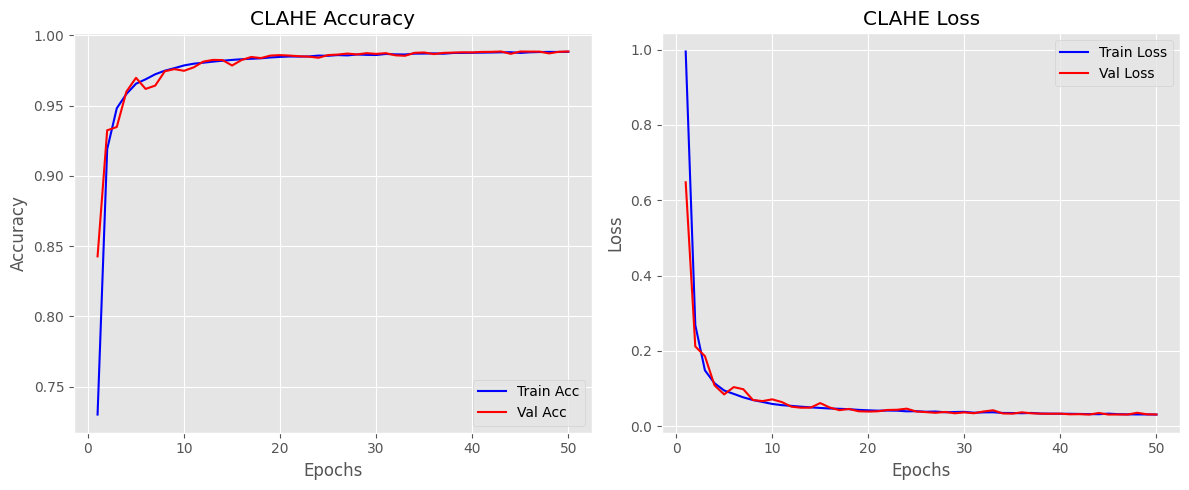


[INFO] Non-CLAHE Metrics (Last Epoch):
Train Accuracy     : 0.9878
Validation Accuracy: 0.9885
Train Loss         : 0.0327
Validation Loss    : 0.0308


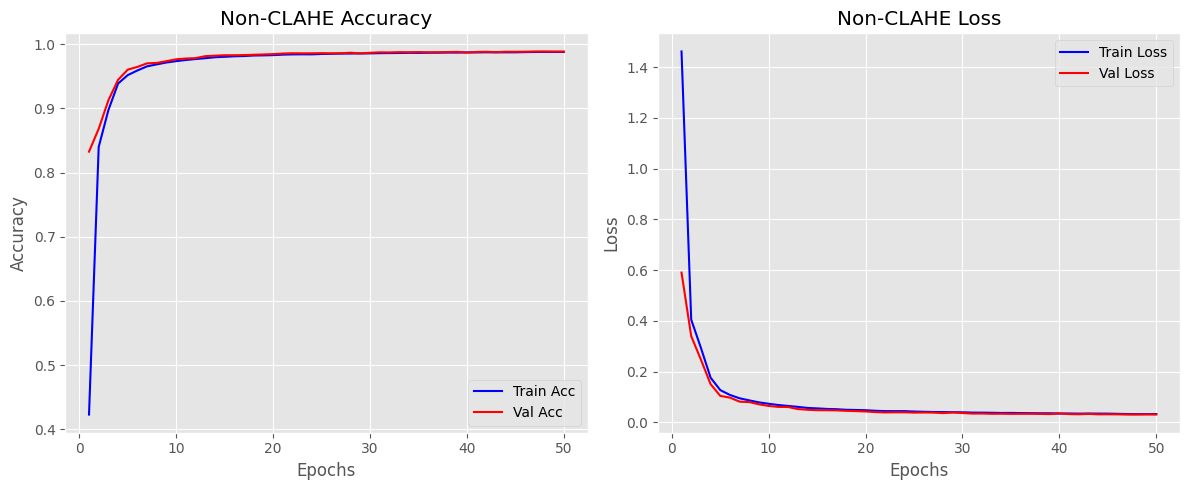

In [ ]:
import matplotlib.pyplot as plt

def plot_history_clean(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Print nilai terakhir
    print(f"\n[INFO] {title} Metrics (Last Epoch):")
    print(f"Train Accuracy     : {acc[-1]:.4f}")
    print(f"Validation Accuracy: {val_acc[-1]:.4f}")
    print(f"Train Loss         : {loss[-1]:.4f}")
    print(f"Validation Loss    : {val_loss[-1]:.4f}")

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Accuracy
    ax[0].plot(epochs, acc, 'b-', label='Train Acc')
    ax[0].plot(epochs, val_acc, 'r-', label='Val Acc')
    ax[0].set_title(f'{title} Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()
    ax[0].grid(True)

    # Loss
    ax[1].plot(epochs, loss, 'b-', label='Train Loss')
    ax[1].plot(epochs, val_loss, 'r-', label='Val Loss')
    ax[1].set_title(f'{title} Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

# Panggil fungsi untuk dua model
plot_history_clean(history_clahe, title='CLAHE')
plot_history_clean(history_non, title='Non-CLAHE')


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import tensorflow as tf

def evaluate_per_class(y_true, y_pred, num_classes=6):
    """
    Evaluasi Mean IoU dan Dice Coefficient per kelas.
    y_true dan y_pred dalam format one-hot (N, H, W, C)
    """
    y_true_label = np.argmax(y_true, axis=-1).flatten()
    y_pred_label = np.argmax(y_pred, axis=-1).flatten()

    iou_scores = []
    dice_scores = []

    print("Evaluasi per kelas:")
    print(f"{'Kelas':<10}{'IoU':>10}{'Dice':>10}")
    print("-" * 30)

    for cls in range(num_classes):
        y_true_cls = (y_true_label == cls).astype(np.uint8)
        y_pred_cls = (y_pred_label == cls).astype(np.uint8)

        intersection = np.sum(y_true_cls * y_pred_cls)
        union = np.sum(y_true_cls) + np.sum(y_pred_cls) - intersection
        dice = (2 * intersection) / (np.sum(y_true_cls) + np.sum(y_pred_cls) + 1e-6)
        iou = intersection / (union + 1e-6)

        iou_scores.append(iou)
        dice_scores.append(dice)

        print(f"{cls:<10}{iou:>10.4f}{dice:>10.4f}")

    mean_iou = np.mean(iou_scores)
    mean_dice = np.mean(dice_scores)

    print("-" * 30)
    print(f"{'Mean':<10}{mean_iou:>10.4f}{mean_dice:>10.4f}")
    return iou_scores, dice_scores


In [ ]:
# Asumsikan kamu sudah punya model dan data:
# model_clahe, model_non
# X_test_clahe, y_test_cat_clahe
# X_test_non, y_test_cat_non
y_test_cat_clahe = to_categorical(y_test_clahe, num_classes=6)
y_test_cat_non = to_categorical(y_test_non, num_classes=6)

# Prediksi
y_pred_clahe = model_clahe.predict(X_test_clahe)
y_pred_non = model_non.predict(X_test_non)

# Evaluasi model CLAHE
print("\nEvaluasi Model CLAHE:")
iou_clahe, dice_clahe = evaluate_per_class(y_test_cat_clahe, y_pred_clahe, num_classes=6)

# Evaluasi model Non-CLAHE
print("\nEvaluasi Model Non-CLAHE:")
iou_non, dice_non = evaluate_per_class(y_test_cat_non, y_pred_non, num_classes=6)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_82']
Received: inputs=Tensor(shape=(32, 128, 128, 1))
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 837ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_123']
Received: inputs=Tensor(shape=(32, 128, 128, 1))
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step

Evaluasi Model CLAHE:
Evaluasi per kelas:
Kelas            IoU      Dice
------------------------------
0             0.9972    0.9986
1             0.9370    0.9675
2             0.9318    0.9647
3             0.5498    0.7095
4             0.9938    0.9969
5             0.8374    0.9115
------------------------------
Mean          0.8745    0.9248

Evaluasi Model Non-CLAHE:
Evaluasi per kelas:
Kelas            IoU      Dice
------------------------------
0             0.9973    0.9986
1             0.9384    0.9682
2             0.9308    0.9642
3             0.5491    0.7089
4             0.9933    0.9967
5             0.8308    0.9076
------------------------------
Mean          0.8733    0.9240


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
import tensorflow as tf

def evaluate_per_class(y_true, y_pred, num_classes=6):
    y_true_label = np.argmax(y_true, axis=-1).flatten()
    y_pred_label = np.argmax(y_pred, axis=-1).flatten()

    iou_scores = []
    dice_scores = []

    print(f"\n{'Kelas':<10}{'IoU':>10}{'Dice':>10}")
    print("-" * 30)

    for cls in range(num_classes):
        y_true_cls = (y_true_label == cls).astype(np.uint8)
        y_pred_cls = (y_pred_label == cls).astype(np.uint8)

        intersection = np.sum(y_true_cls * y_pred_cls)
        union = np.sum(y_true_cls) + np.sum(y_pred_cls) - intersection
        dice = (2 * intersection) / (np.sum(y_true_cls) + np.sum(y_pred_cls) + 1e-6)
        iou = intersection / (union + 1e-6)

        iou_scores.append(iou)
        dice_scores.append(dice)

        print(f"{cls:<10}{iou:>10.4f}{dice:>10.4f}")

    mean_iou = np.mean(iou_scores)
    mean_dice = np.mean(dice_scores)

    return mean_iou, mean_dice

def final_evaluation(model, X_test, y_test_onehot, mode_name, num_classes=6):
    print(f"\n{'='*20} FINAL EVALUATION: {mode_name} {'='*20}")

    # Prediksi dan konversi
    y_pred = model.predict(X_test)
    y_true_labels = np.argmax(y_test_onehot, axis=-1).flatten()
    y_pred_labels = np.argmax(y_pred, axis=-1).flatten()

    # Accuracy pixel-wise
    acc = accuracy_score(y_true_labels, y_pred_labels)
    print(f"\n[+] Overall Accuracy: {acc:.4f}")

    # Mean IoU dan Dice
    mean_iou, mean_dice = evaluate_per_class(y_test_onehot, y_pred, num_classes=num_classes)
    print(f"\n[+] Macro Mean IoU  : {mean_iou:.4f}")
    print(f"[+] Macro Dice     : {mean_dice:.4f}")

    print(f"{'='*60}\n")
    return acc, mean_iou, mean_dice


In [ ]:
# Asumsi:
# model_clahe, model_non
# X_test_clahe, y_test_cat_clahe
# X_test_non, y_test_cat_non

acc_c, iou_c, dice_c = final_evaluation(model_clahe, X_test_clahe, y_test_cat_clahe, mode_name='CLAHE')
acc_n, iou_n, dice_n = final_evaluation(model_non, X_test_non, y_test_cat_non, mode_name='Non-CLAHE')



==================== FINAL EVALUATION: CLAHE ====================
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

[+] Overall Accuracy: 0.9883

Kelas            IoU      Dice
------------------------------
0             0.9972    0.9986
1             0.9370    0.9675
2             0.9318    0.9647
3             0.5498    0.7095
4             0.9938    0.9969
5             0.8374    0.9115

[+] Macro Mean IoU  : 0.8745
[+] Macro Dice     : 0.9248


==================== FINAL EVALUATION: Non-CLAHE ====================
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

[+] Overall Accuracy: 0.9881

Kelas            IoU      Dice
------------------------------
0             0.9973    0.9986
1             0.9384    0.9682
2             0.9308    0.9642
3             0.5491    0.7089
4             0.9933    0.9967
5             0.8308    0.9076

[+] Macro Mean IoU  : 0.8733
[+] Macro Dice     : 0.9240



In [ ]:
import random
def random_pic():
    test_img_number = random.randint(0, len(y_test_category))
    test_img = X_test[test_img_number]
    ground_truth=y_test[test_img_number]
    test_img_norm=test_img[:,:,0][:,:,None]
    test_img_input=np.expand_dims(test_img_norm, 0)
    prediction = (model.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]


    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img[:,:,0], cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0], cmap='jet')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img, cmap='jet')
    plt.show()


#Validation

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

def compare_predictions(model_clahe, model_non, X_test, y_test):
    idx = random.randint(0, len(y_test) - 1)

    # Ambil sample acak
    test_img = X_test[idx]
    ground_truth = y_test[idx]

    # Siapkan input model (expand dims dan channel check)
    test_img_input = np.expand_dims(test_img, 0)
    if test_img_input.shape[-1] == 1:
        test_img_input = test_img_input  # (1, H, W, 1)
    else:
        test_img_input = test_img_input[..., np.newaxis]  # Jika grayscale tanpa channel

    # Prediksi dari masing-masing model
    pred_clahe = model_clahe.predict(test_img_input)
    pred_non = model_non.predict(test_img_input)

    # Argmax pada channel untuk ambil prediksi kelas
    pred_clahe_mask = np.argmax(pred_clahe, axis=3)[0]
    pred_non_mask = np.argmax(pred_non, axis=3)[0]

    # Tampilkan hasil
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 4, 1)
    plt.title('Input Image')
    plt.imshow(test_img.squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title('Ground Truth')
    plt.imshow(ground_truth.squeeze(), cmap='jet')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title('Prediction (CLAHE)')
    plt.imshow(pred_clahe_mask, cmap='jet')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.title('Prediction (Non_CLAHE)')
    plt.imshow(pred_non_mask, cmap='jet')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


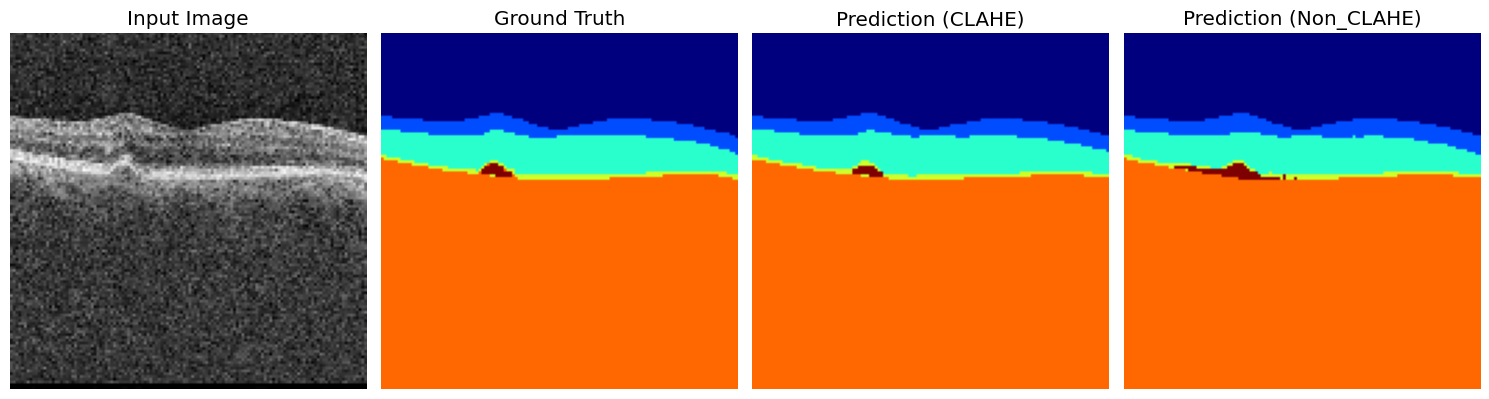

In [ ]:
compare_predictions(model_clahe, model_non, X_test_clahe, y_test_clahe)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


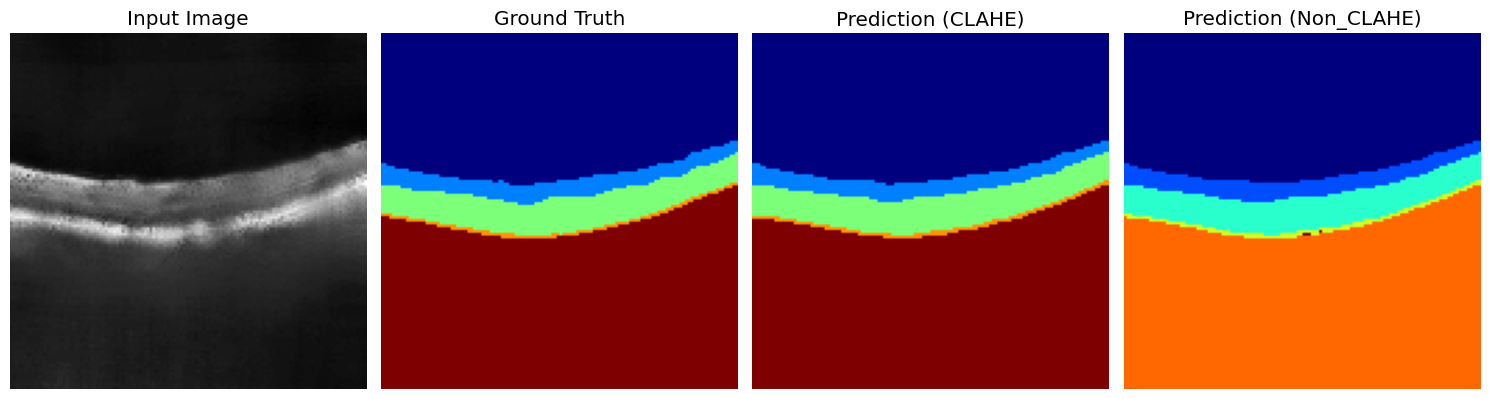

In [ ]:
compare_predictions(model_clahe, model_non, X_test_clahe, y_test_clahe)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


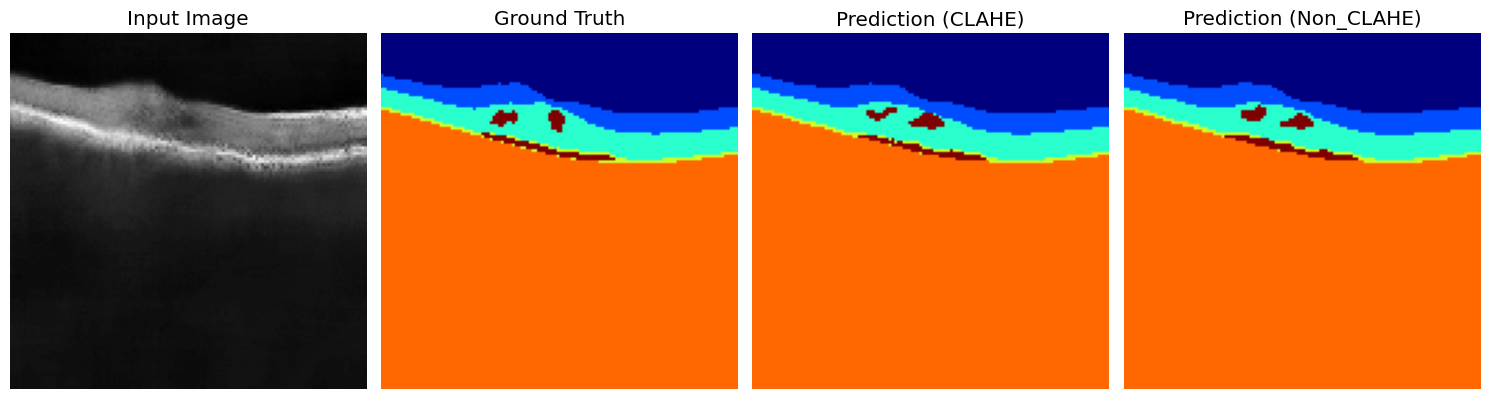

In [ ]:
compare_predictions(model_clahe, model_non, X_test_clahe, y_test_clahe)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


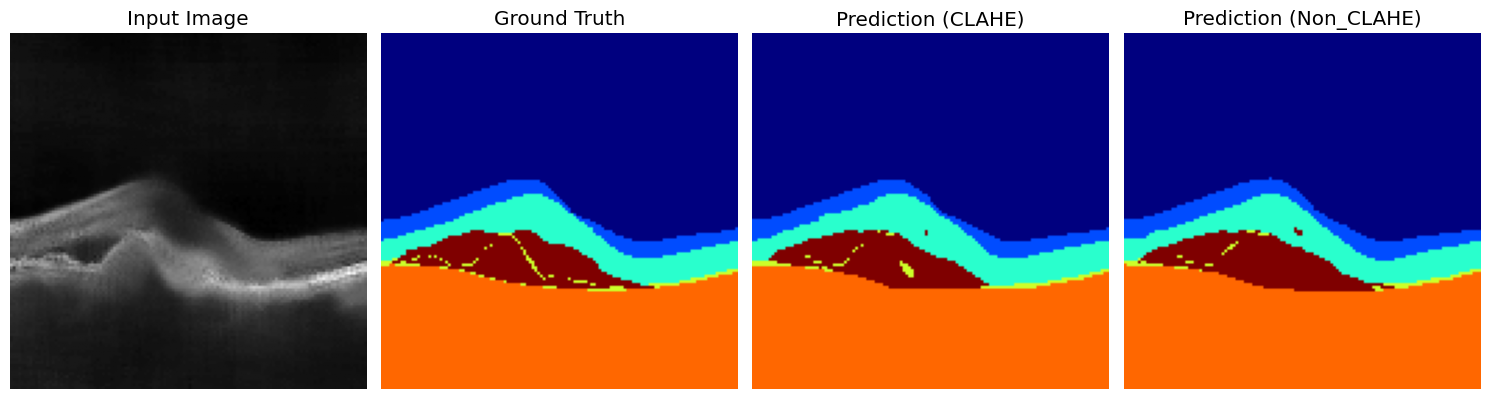

In [ ]:
compare_predictions(model_clahe, model_non, X_test_clahe, y_test_clahe)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


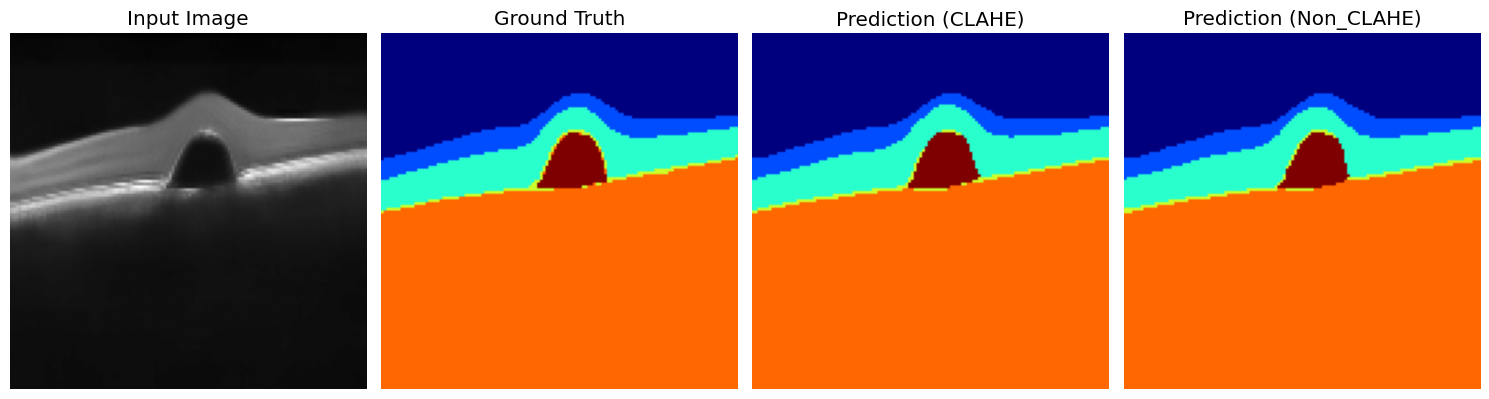

In [ ]:
compare_predictions(model_clahe, model_non, X_test_non, y_test_non)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


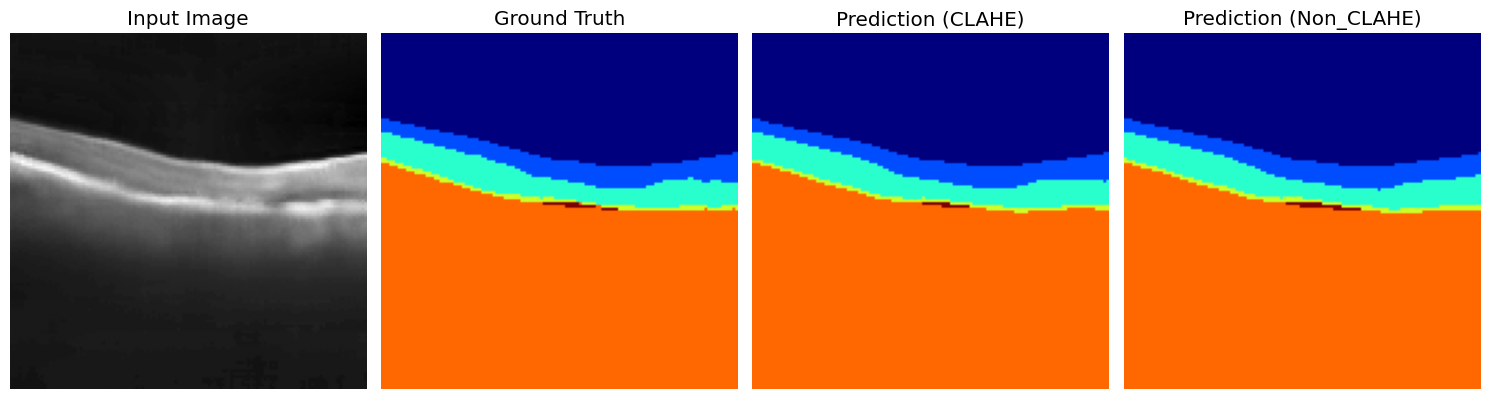

In [ ]:
compare_predictions(model_clahe, model_non, X_test_clahe, y_test_clahe)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


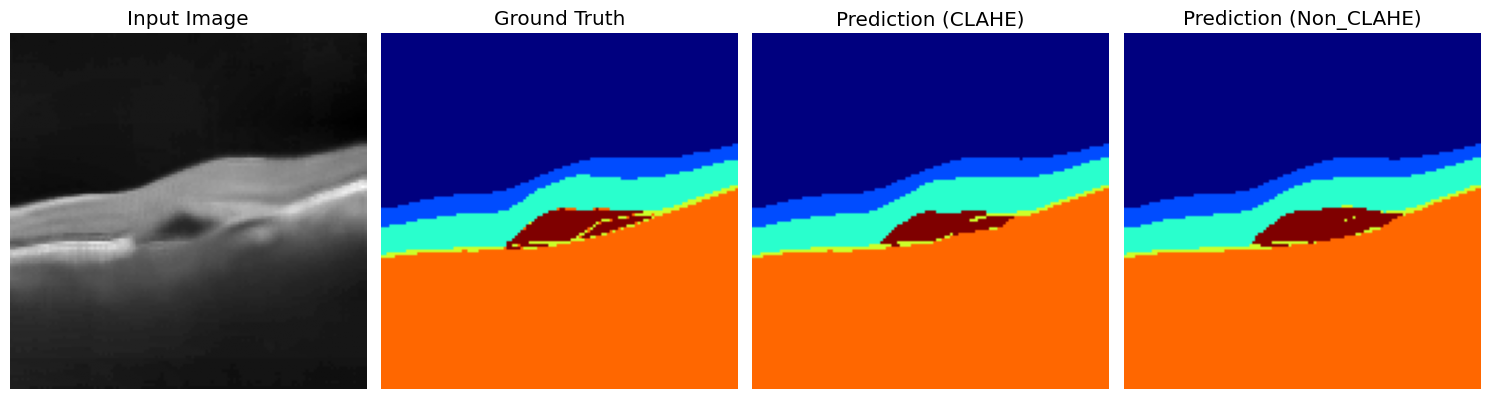

In [ ]:
compare_predictions(model_clahe, model_non, X_test_clahe, y_test_clahe)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


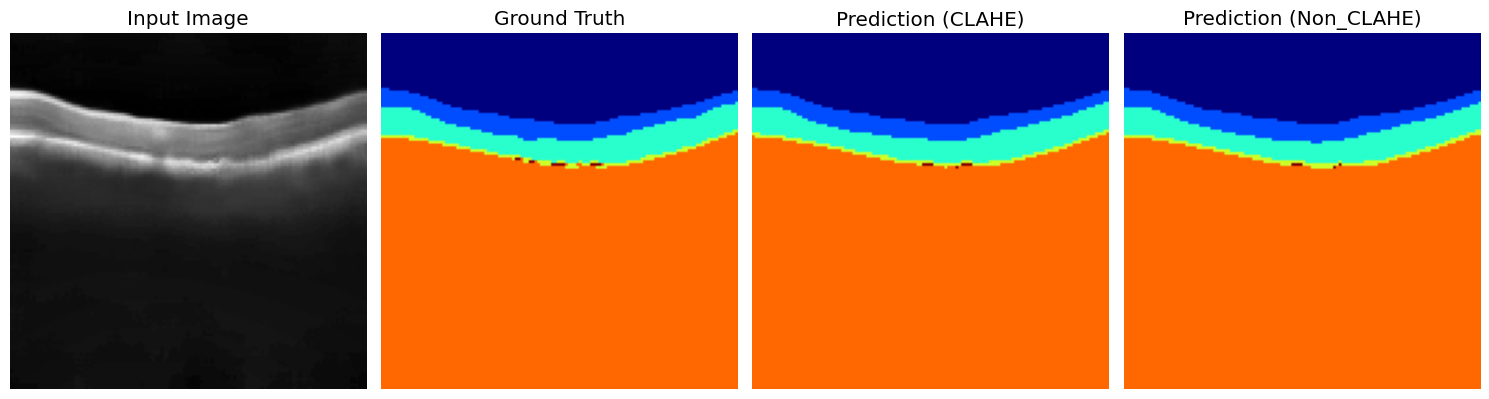

In [ ]:
compare_predictions(model_clahe, model_non, X_test_clahe, y_test_clahe)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


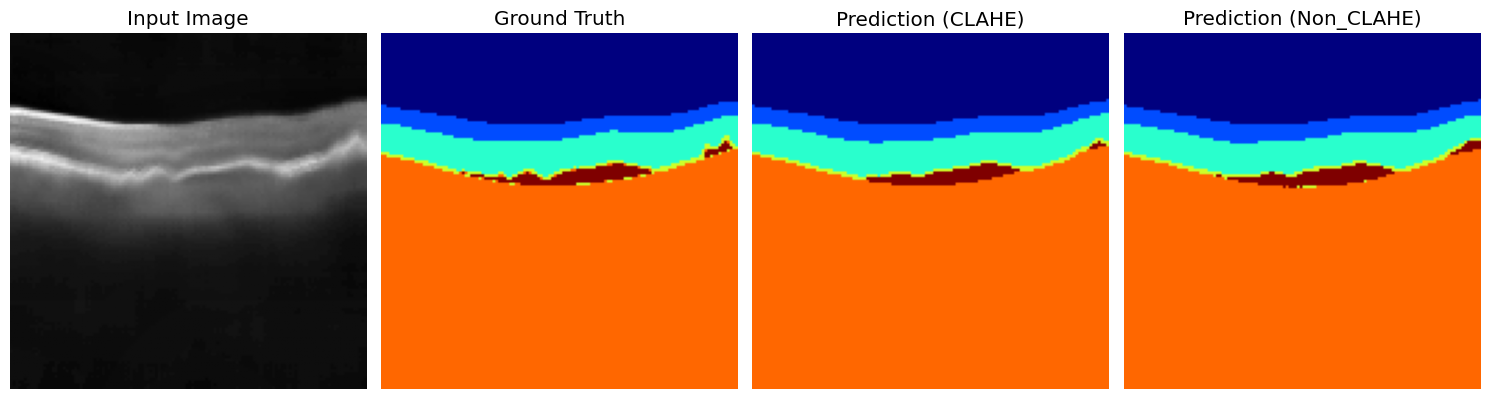

In [ ]:
compare_predictions(model_clahe, model_non, X_test_clahe, y_test_clahe)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


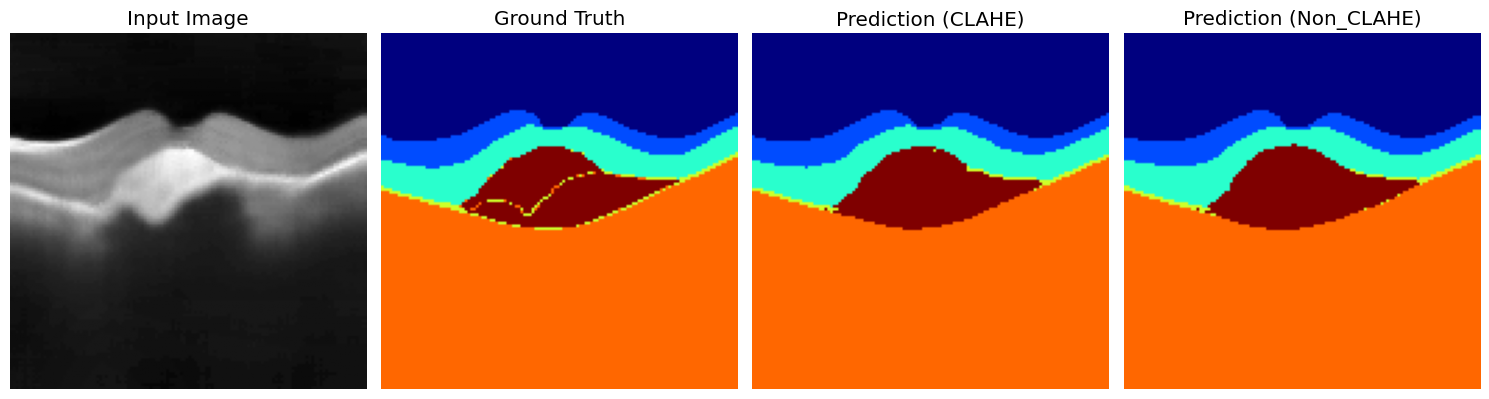

In [ ]:
compare_predictions(model_clahe, model_non, X_test_clahe, y_test_clahe)

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_f = tf.reshape(y_true, [-1, tf.shape(y_true)[-1]])
    y_pred_f = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])

    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    denom = tf.reduce_sum(y_true_f + y_pred_f, axis=0)
    dice = (2. * intersection + smooth) / (denom + smooth)
    return tf.reduce_mean(dice)

class MeanIoUCustom(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='mean_iou', **kwargs):
        super(MeanIoUCustom, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.miou = tf.keras.metrics.MeanIoU(num_classes=num_classes)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)
        self.miou.update_state(y_true, y_pred)

    def result(self):
        return self.miou.result()

    def reset_states(self):
        self.miou.reset_states()

def compare_predictions(model_clahe, model_non, X_test, y_test, num_classes):
    idx = random.randint(0, len(y_test) - 1)

    # Ambil sample acak
    test_img = X_test[idx]
    ground_truth = y_test[idx]

    # Siapkan input model (expand dims dan channel check)
    test_img_input = np.expand_dims(test_img, 0)
    if test_img_input.ndim == 3:
        test_img_input = test_img_input[..., np.newaxis]

    # Prediksi dari masing-masing model
    pred_clahe = model_clahe.predict(test_img_input)
    pred_non = model_non.predict(test_img_input)

    # Argmax channel prediksi
    pred_clahe_mask = np.argmax(pred_clahe, axis=-1)[0]
    pred_non_mask = np.argmax(pred_non, axis=-1)[0]

    # One-hot encoding ground truth jika belum
    # Tangani berbagai format ground_truth
    if ground_truth.ndim == 2:
        ground_truth_mask = ground_truth
    elif ground_truth.ndim == 3:
        if ground_truth.shape[-1] == 1:
            # (H, W, 1) → squeeze jadi (H, W)
            ground_truth_mask = np.squeeze(ground_truth, axis=-1)
        elif ground_truth.shape[-1] == num_classes:
            # One-hot encoded
            ground_truth_mask = np.argmax(ground_truth, axis=-1)
        else:
            raise ValueError(f"Dimensi akhir ground_truth tidak dikenali: {ground_truth.shape[-1]}")
    else:
        raise ValueError(f"Bentuk ground_truth tidak dikenali: {ground_truth.shape}")

    # Konversi ke one-hot untuk dice/iou metric
    y_true_one_hot = tf.one_hot(ground_truth_mask, depth=num_classes)


    # One-hot encoding prediksi
    y_pred_clahe_one_hot = tf.one_hot(pred_clahe_mask, depth=num_classes)
    y_pred_non_one_hot = tf.one_hot(pred_non_mask, depth=num_classes)

    # DICE
    dice_clahe = dice_coefficient(y_true_one_hot, y_pred_clahe_one_hot).numpy()
    dice_non = dice_coefficient(y_true_one_hot, y_pred_non_one_hot).numpy()

    # Mean IoU
    miou_clahe_metric = MeanIoUCustom(num_classes=num_classes)
    miou_clahe_metric.update_state(y_true_one_hot, y_pred_clahe_one_hot)
    miou_clahe = miou_clahe_metric.result().numpy()

    miou_non_metric = MeanIoUCustom(num_classes=num_classes)
    miou_non_metric.update_state(y_true_one_hot, y_pred_non_one_hot)
    miou_non = miou_non_metric.result().numpy()

    # Visualisasi
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 4, 1)
    plt.title('Input Image')
    plt.imshow(test_img.squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title('Ground Truth')
    plt.imshow(ground_truth_mask, cmap='jet')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title(f'CLAHE\nDice: {dice_clahe:.4f}\nIoU: {miou_clahe:.4f}')
    plt.imshow(pred_clahe_mask, cmap='jet')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.title(f'Non-CLAHE\nDice: {dice_non:.4f}\nIoU: {miou_non:.4f}')
    plt.imshow(pred_non_mask, cmap='jet')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


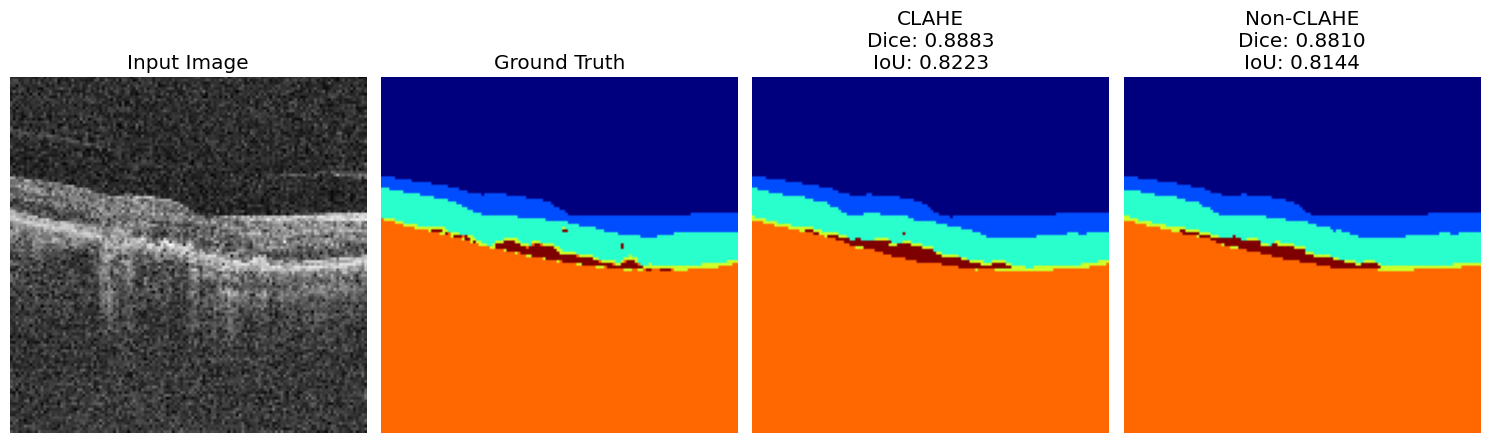

In [ ]:
compare_predictions(model_clahe, model_non, X_test_clahe, y_test_clahe, num_classes=6)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


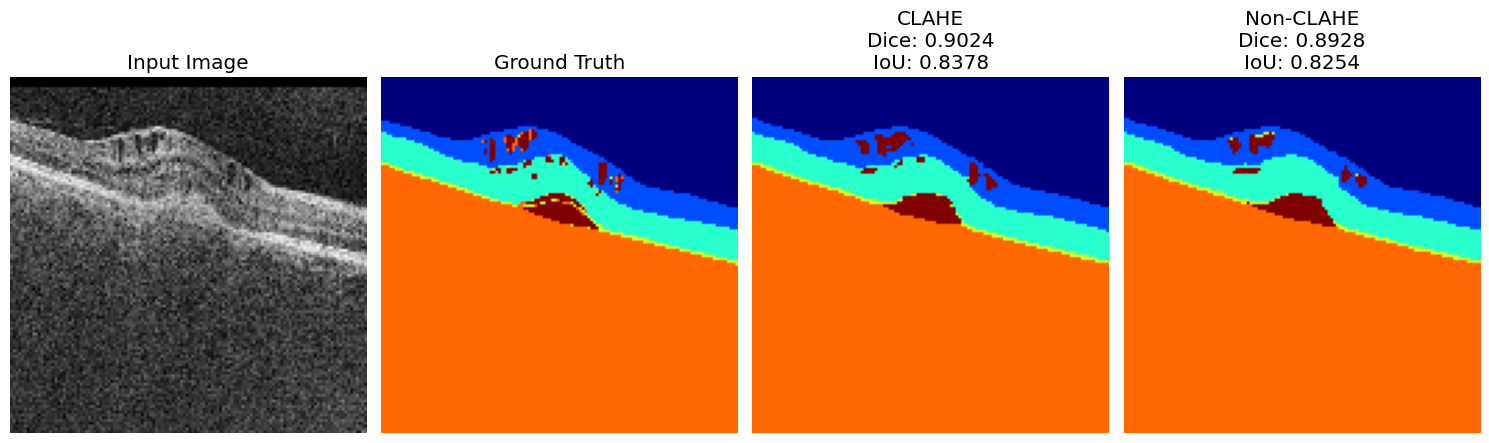

In [ ]:
compare_predictions(model_clahe, model_non, X_test_clahe, y_test_clahe, num_classes=6)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


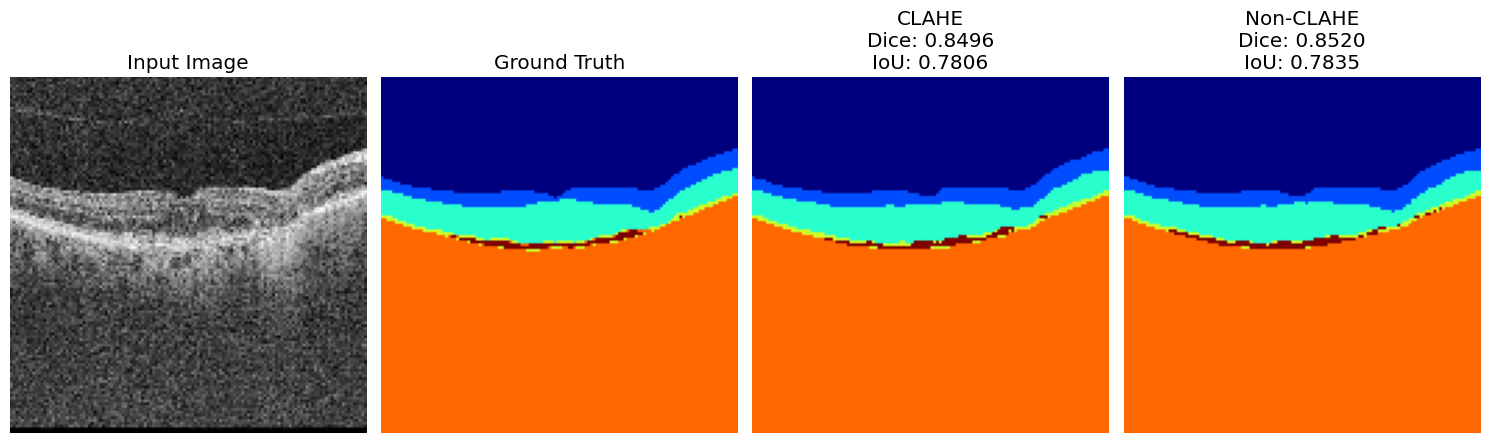

In [ ]:
compare_predictions(model_clahe, model_non, X_test_clahe, y_test_clahe, num_classes=6)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


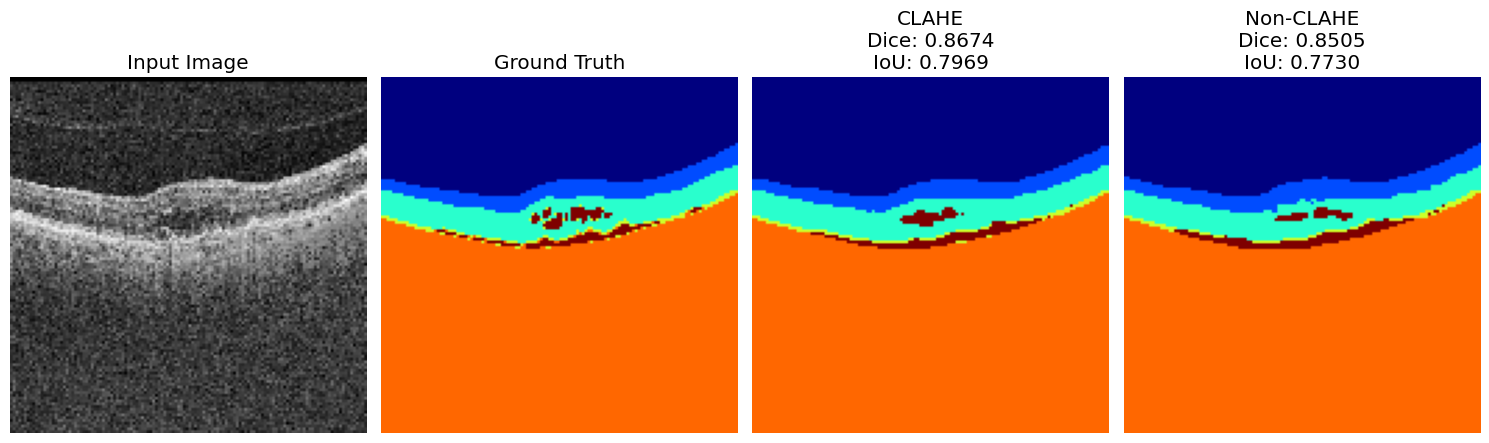

In [ ]:
compare_predictions(model_clahe, model_non, X_test_clahe, y_test_clahe, num_classes=6)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


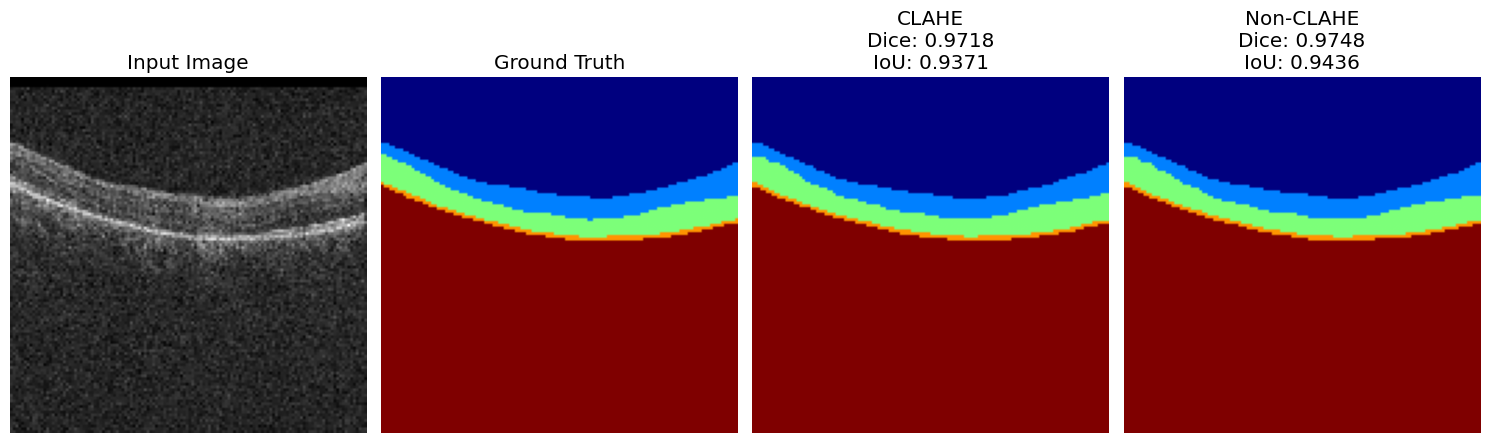

In [ ]:
compare_predictions(model_clahe, model_non, X_test_non, y_test_non, num_classes=6)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


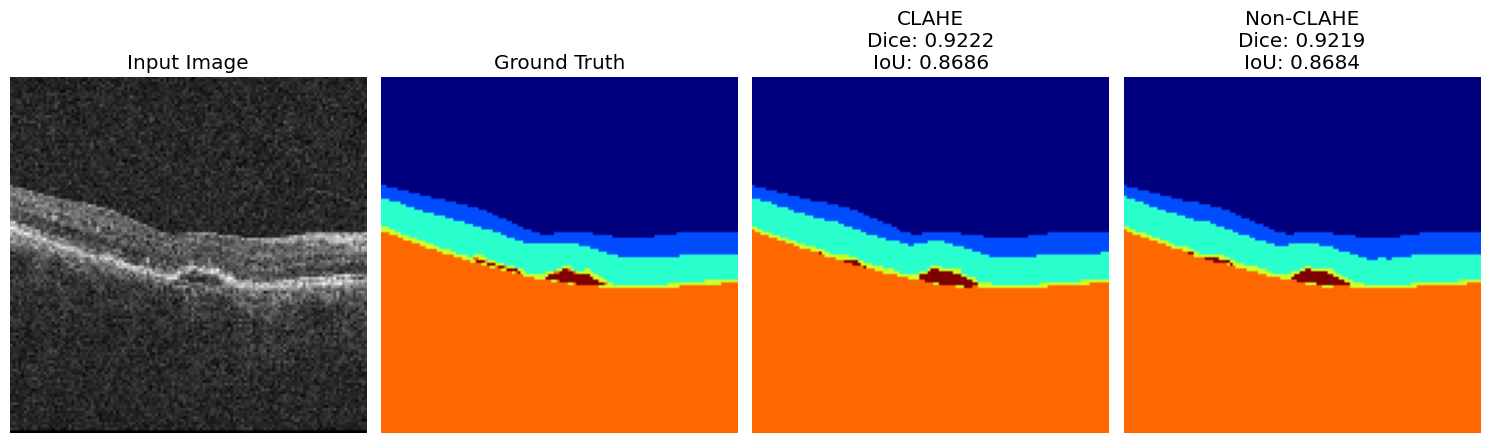

In [ ]:
compare_predictions(model_clahe, model_non, X_test_non, y_test_non, num_classes=6)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


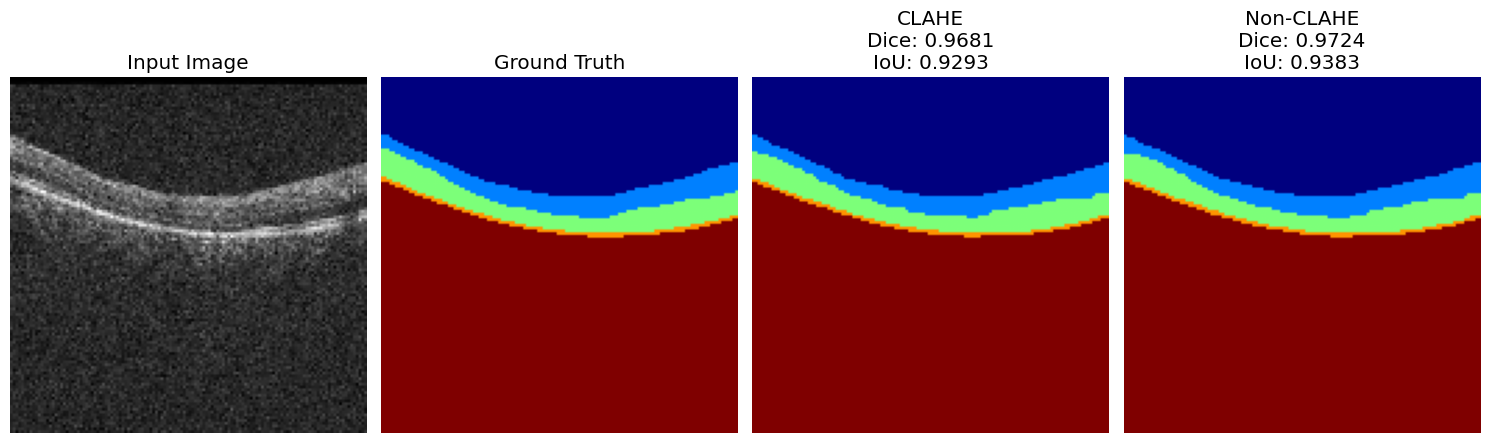

In [ ]:
compare_predictions(model_clahe, model_non, X_test_non, y_test_non, num_classes=6)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


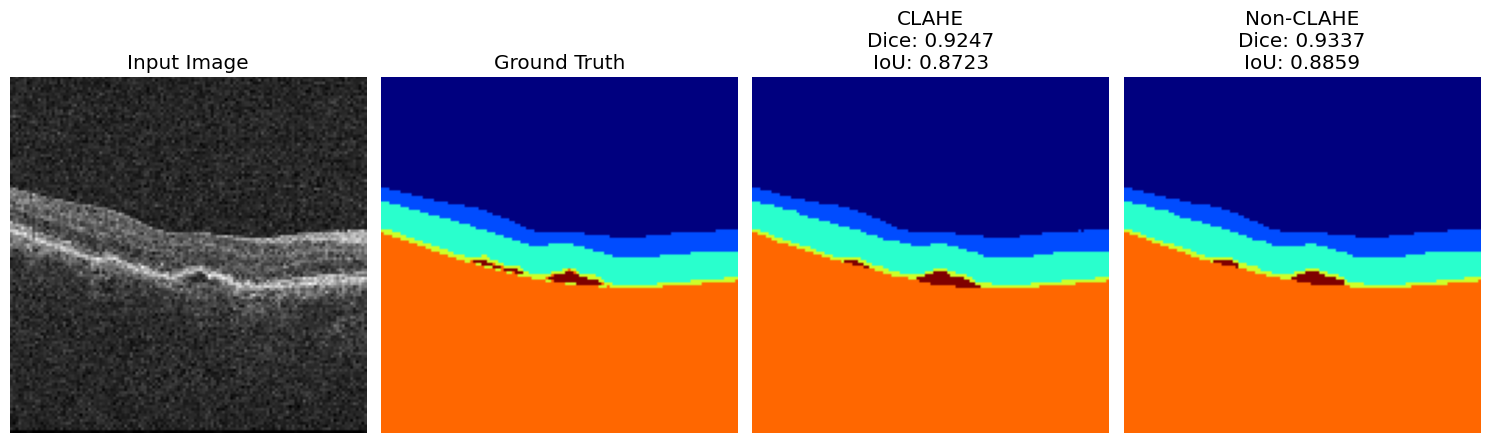

In [ ]:
compare_predictions(model_clahe, model_non, X_test_non, y_test_non, num_classes=6)

#Validation data RS


Loading validation images from: /content/GDrive/MyDrive/dataset RS/OCT
Found 36 images.


/tmp/ipython-input-59-3286646797.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img_path in tqdm_notebook(image_files, desc="Loading & Resizing"):


Loading & Resizing:   0%|          | 0/36 [00:00<?, ?it/s]

Validation images shape after loading and resizing: (36, 128, 128, 1)
Validation images shape after CLAHE and norm: (36, 128, 128, 1)
Validation images shape after norm: (36, 128, 128, 1)

Making predictions on validation data...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
Predictions shape (CLAHE): (36, 128, 128, 6)
Predictions shape (Non-CLAHE): (36, 128, 128, 6)

Displaying example predictions on validation data:


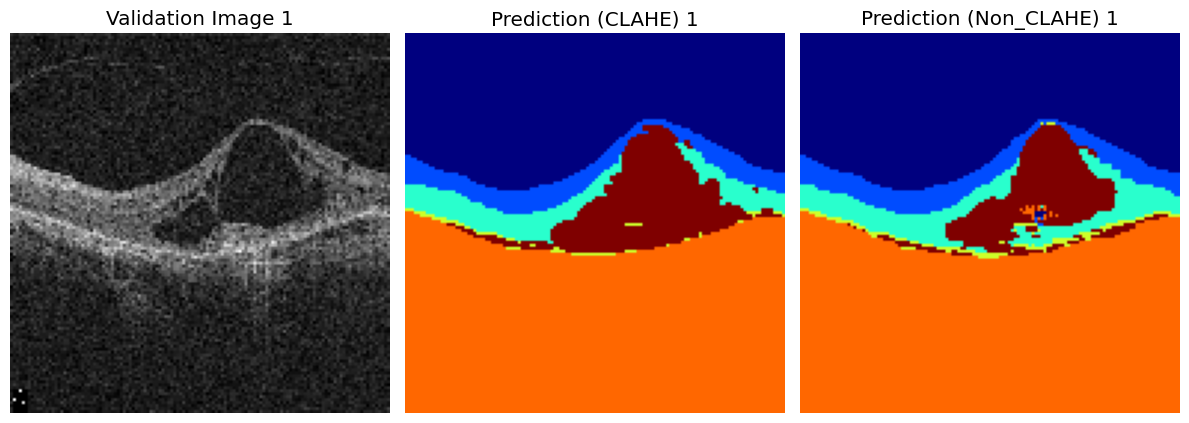

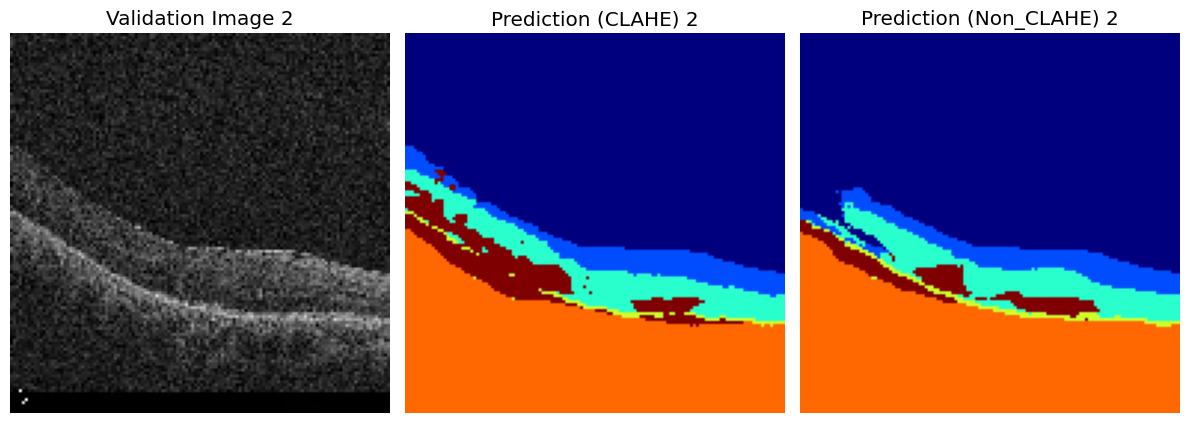

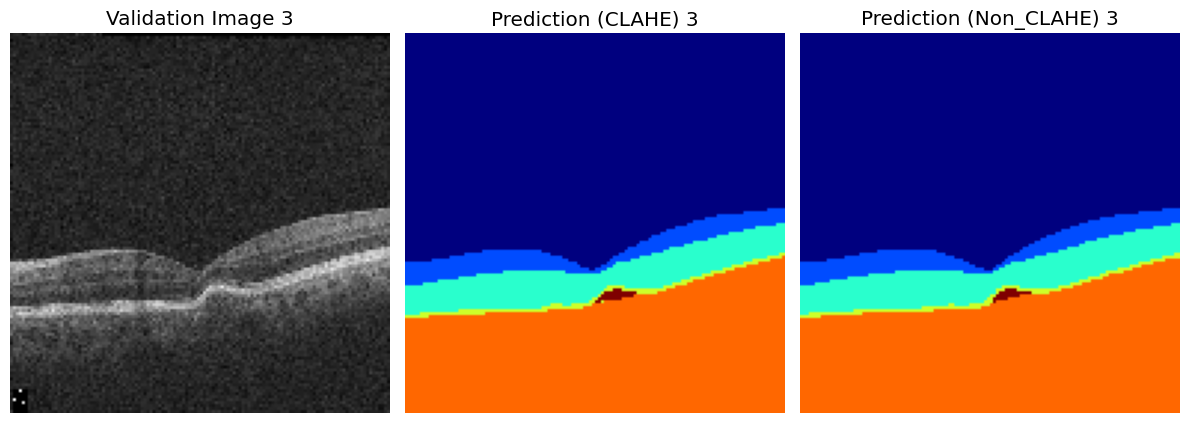

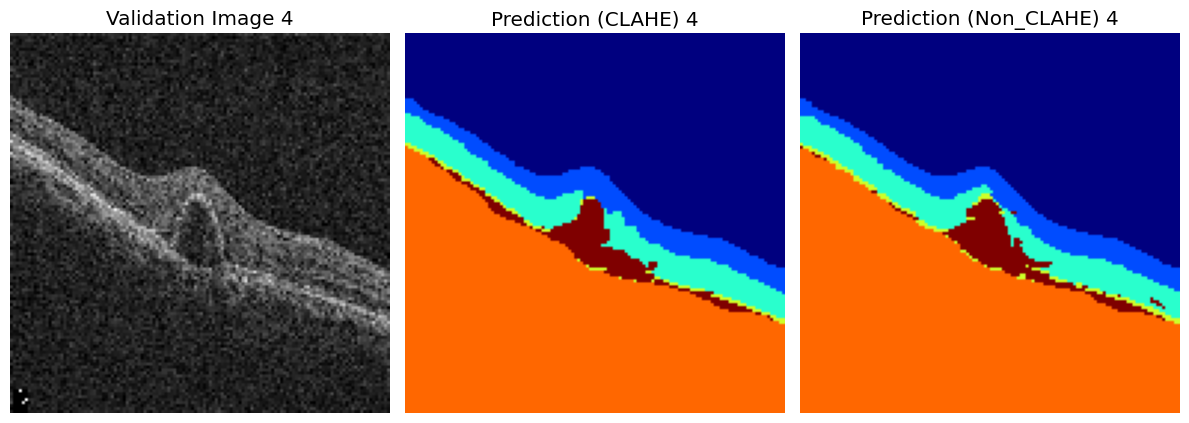

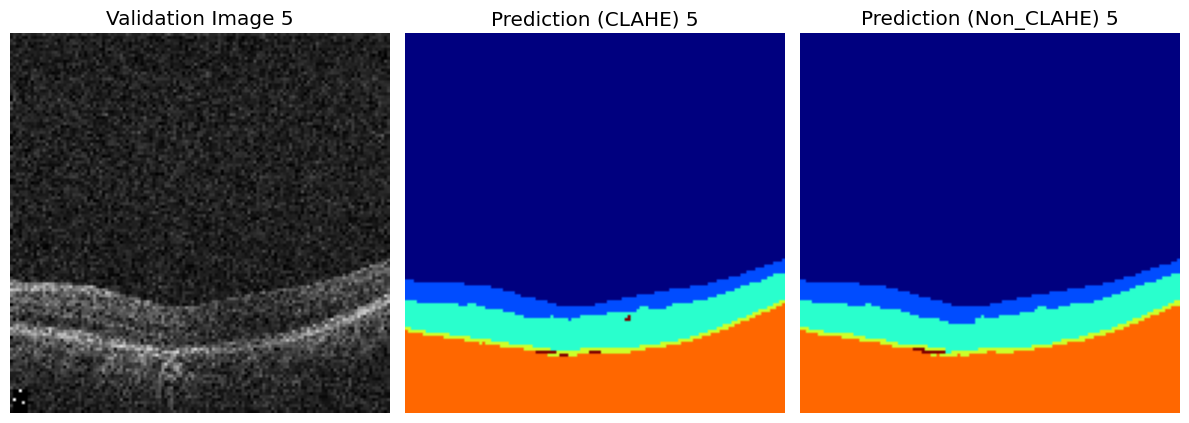

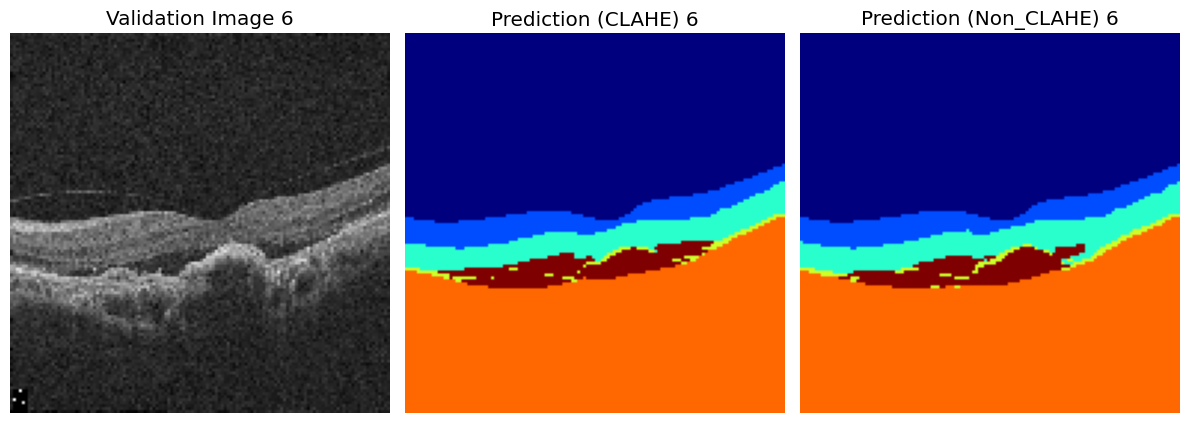

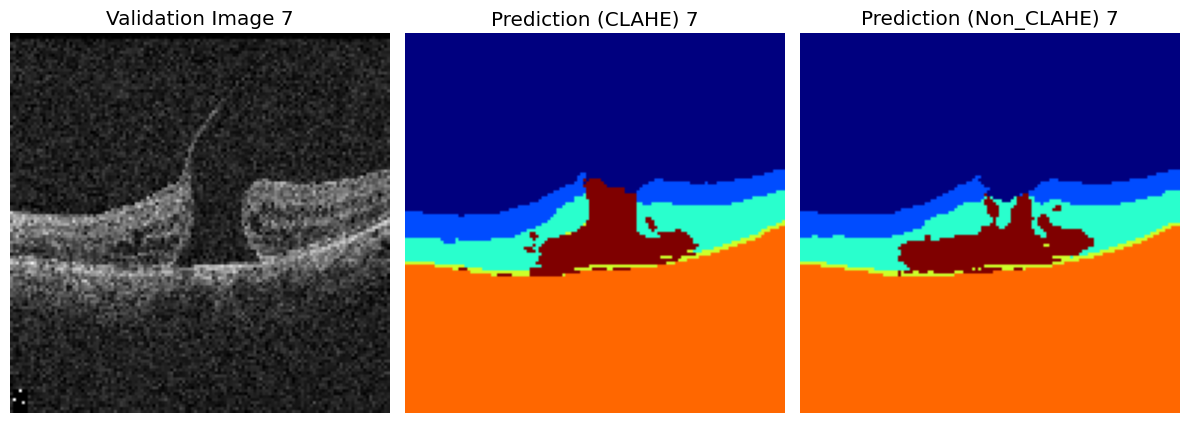

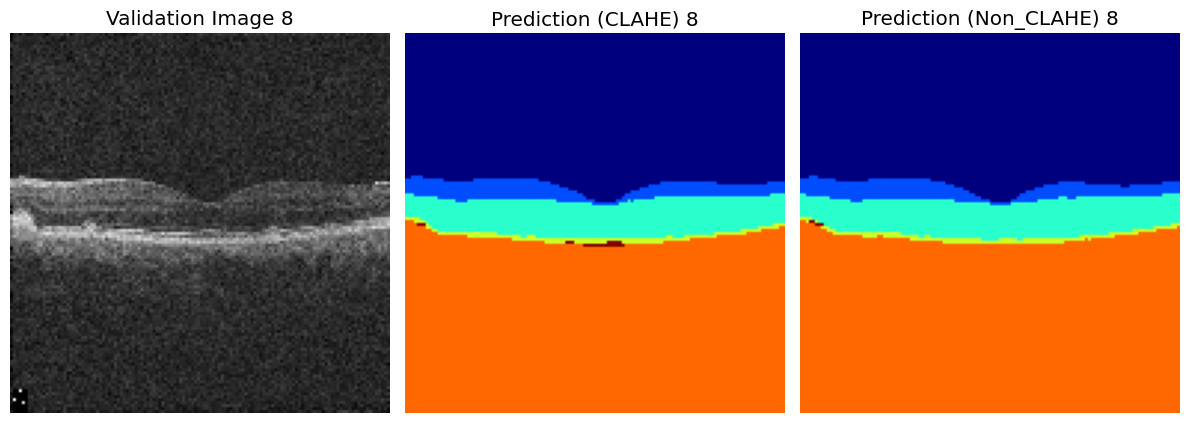

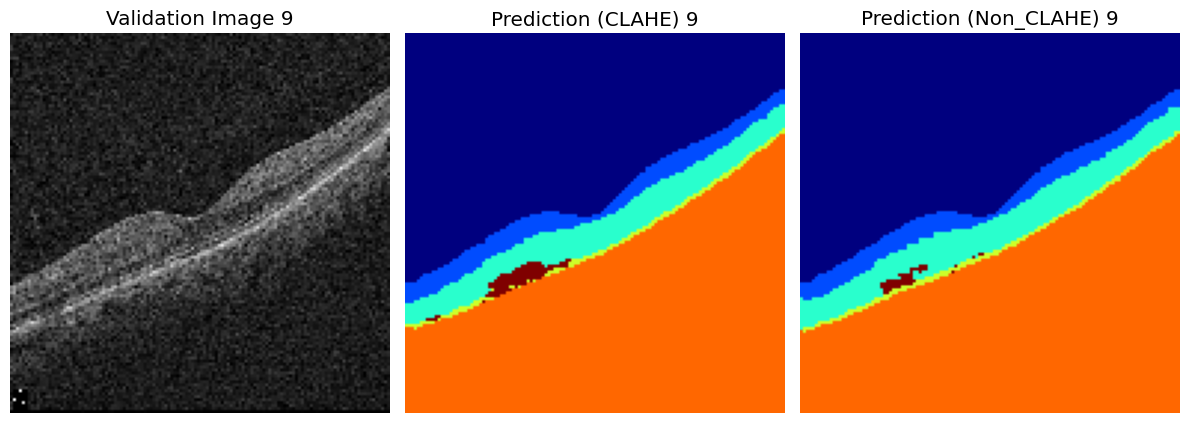

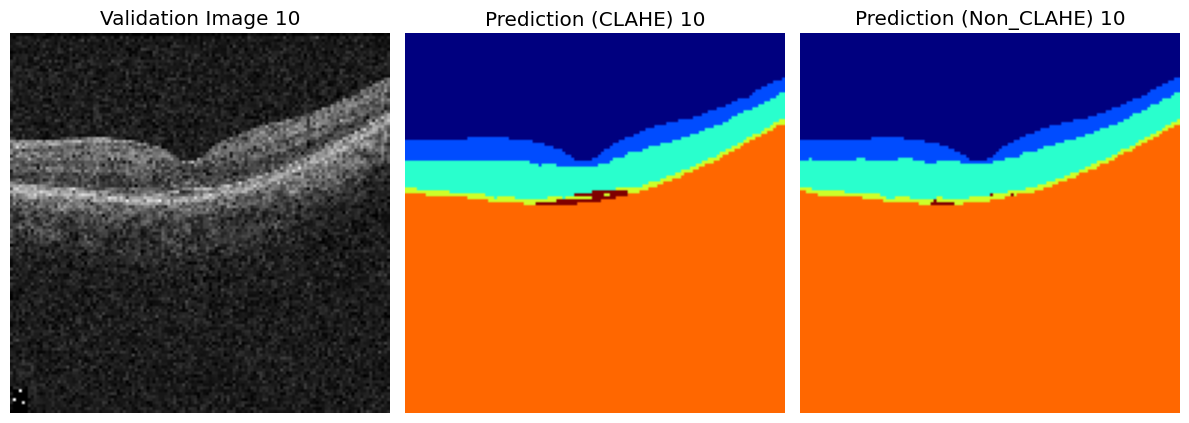


Finished displaying 10 validation prediction examples.

Note: Metrics (IoU, Dice, Accuracy) cannot be calculated for this validation dataset as it lacks ground truth masks.


In [ ]:
# prompt: buatkan untuk test kedua model menggunakan data yang ada disini /content/GDrive/MyDrive/dataset RS/OCT

# Asumsi:
# model_clahe, model_non sudah di-load
# Fungsi resize_image, apply_clahe_batch, min_max_normalize_batch sudah didefinisikan

# Path ke dataset validasi
VALIDATION_DATA_PATH = "/content/GDrive/MyDrive/dataset RS/OCT"

def get_validation_images(validation_path, target_size=(im_height, im_width)):
    """
    Loads and preprocesses validation images from the specified path.
    """
    val_images = []
    image_files = [os.path.join(validation_path, f) for f in os.listdir(validation_path) if f.endswith('.jpg') or f.endswith('.png')] # Sesuaikan ekstensi file jika perlu

    print(f"\nLoading validation images from: {validation_path}")
    print(f"Found {len(image_files)} images.")

    if not image_files:
        print("No image files found in the validation path.")
        return np.array([])

    for img_path in tqdm_notebook(image_files, desc="Loading & Resizing"):
        try:
            img = imread(img_path, as_gray=True) # Baca sebagai grayscale
            img_resized = resize_image(img, target_size)
            val_images.append(img_resized)
        except Exception as e:
            print(f"Error loading or processing image {img_path}: {e}")
            continue

    if not val_images:
        print("No valid images were loaded.")
        return np.array([])

    val_images = np.array(val_images)
    # Add channel dimension if it's grayscale (H, W) -> (H, W, 1)
    if val_images.ndim == 3:
        val_images = np.expand_dims(val_images, axis=-1)

    return val_images

# 1. Load data validasi
X_validation = get_validation_images(VALIDATION_DATA_PATH)

if X_validation.size == 0:
    print("Cannot proceed with evaluation as no validation images were loaded.")
else:
    print(f"Validation images shape after loading and resizing: {X_validation.shape}")

    # 2. Preprocess data validasi (sesuaikan dengan preprocessing data training)
    # Preprocessing CLAHE
    X_validation_clahe = apply_clahe_batch(X_validation.squeeze()) # CLAHE expects (N, H, W)
    X_validation_clahe = np.expand_dims(X_validation_clahe, axis=-1) # Add channel back (N, H, W, 1)
    X_validation_clahe_norm = min_max_normalize_batch(X_validation_clahe)

    # Preprocessing Non-CLAHE (hanya normalisasi)
    X_validation_norm = min_max_normalize_batch(X_validation)

    print(f"Validation images shape after CLAHE and norm: {X_validation_clahe_norm.shape}")
    print(f"Validation images shape after norm: {X_validation_norm.shape}")

    # 3. Lakukan prediksi menggunakan kedua model
    print("\nMaking predictions on validation data...")
    predictions_clahe = model_clahe.predict(X_validation_clahe_norm)
    predictions_non = model_non.predict(X_validation_norm)

    print("Predictions shape (CLAHE):", predictions_clahe.shape)
    print("Predictions shape (Non-CLAHE):", predictions_non.shape)

    # Catatan: Dataset validasi dari /content/GDrive/MyDrive/dataset RS/OCT
    # sepertinya hanya berisi gambar (input X) dan TIDAK ADA label (ground truth Y).
    # Karena tidak ada label, kita tidak bisa menghitung metrik evaluasi (Accuracy, IoU, Dice).
    # Yang bisa kita lakukan hanyalah menampilkan beberapa contoh prediksi.

    # 4. Tampilkan beberapa contoh visualisasi prediksi
    print("\nDisplaying example predictions on validation data:")

    num_examples_to_show = min(10, len(X_validation)) # Tampilkan maksimal 10 contoh

    for i in range(num_examples_to_show):
        img_val_input = X_validation[i]
        pred_clahe_mask = np.argmax(predictions_clahe[i], axis=-1)
        pred_non_mask = np.argmax(predictions_non[i], axis=-1)

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 3, 1)
        plt.title(f'Validation Image {i+1}')
        plt.imshow(img_val_input.squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title(f'Prediction (CLAHE) {i+1}')
        plt.imshow(pred_clahe_mask, cmap='jet', vmin=0, vmax=n_classes-1) # Pastikan colormap sesuai kelas
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title(f'Prediction (Non_CLAHE) {i+1}')
        plt.imshow(pred_non_mask, cmap='jet', vmin=0, vmax=n_classes-1) # Pastikan colormap sesuai kelas
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    print(f"\nFinished displaying {num_examples_to_show} validation prediction examples.")
    print("\nNote: Metrics (IoU, Dice, Accuracy) cannot be calculated for this validation dataset as it lacks ground truth masks.")

